In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "drive/My Drive/"

/content/drive/My Drive


In [0]:
import sys
sys.path.append('./analysis/bayes/src')

In [0]:
from bayes.vi import VIModel, normal_prior_dist, transform_param
from bayes.nn import TensorModule, TensorBatchNorm1d, TensorLinear
from bayes.distributions.normal import CustomNormal

In [0]:
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as torchdist
import torch.nn as nn
import torch.nn.functional as F
import itertools
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

## Data

In [0]:
normal_dist = torchdist.Normal(loc=torch.tensor(0.), scale=torch.tensor(1.))

In [0]:
x = normal_dist.sample()

In [8]:
x

tensor(-1.2977)

In [0]:
x = normal_dist.sample([100])

In [10]:
x

tensor([ 0.9187,  0.9865, -0.0272, -0.1267,  0.6734, -0.5887, -1.8755,  1.3247,
         0.3827,  0.4960,  0.4722, -0.1176, -1.5051, -0.5716,  1.0241,  0.4393,
         0.0205,  1.6469, -1.7930, -1.2664, -0.1540, -1.2972,  0.9867,  0.9815,
        -0.3755, -1.0313,  0.9499, -0.2331,  0.2634,  0.4917,  0.6236,  1.5976,
         0.2925,  1.2245,  1.2198,  1.9377, -0.4541,  1.2308, -1.0604, -0.2834,
        -0.0957, -1.0479,  0.4690,  1.1935,  0.8129, -0.4867,  0.7882, -0.5266,
        -0.4328, -0.0492, -1.1406, -0.3900,  0.1079,  1.4592,  0.2805,  1.2782,
         0.3073,  0.6778,  0.1402, -0.8486,  1.3810, -1.4417, -0.6248, -1.3872,
        -0.3510, -1.5746, -0.7819,  0.5029,  0.9038, -0.6571,  0.0462, -1.0336,
         0.3062,  0.1437, -1.1462, -0.0879,  0.2154,  0.4652, -0.3020,  0.9288,
         0.9196, -0.9968,  0.3680, -1.0276, -2.5575,  0.4391,  1.2633, -0.4408,
         0.2154, -0.2064, -0.1532,  1.3472, -0.7441, -0.9818,  0.5039,  0.2924,
        -2.1328,  0.0805, -0.2565, -0.24

(array([ 2.,  2.,  6., 11., 13., 18., 21., 14., 10.,  3.]),
 array([-2.557468  , -2.1079524 , -1.6584368 , -1.2089212 , -0.7594056 ,
        -0.30989003,  0.13962555,  0.58914113,  1.0386567 ,  1.4881723 ,
         1.9376879 ], dtype=float32),
 <a list of 10 Patch objects>)

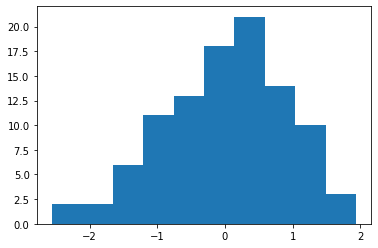

In [11]:
plt.hist(x.detach().numpy())

In [0]:
def toy_poly():
    x = 5 * torch.rand(100, 1)
    # linear_op = -3 - 4*x + x**2
    # linear_op = -3 - 4*x + 2*x**2 - x*x*x / 5
    linear_op = 4 * torch.sin(x*2)
    y = torchdist.Normal(linear_op, 0.5).sample()
    return x, y

x_train, y_train = toy_poly()

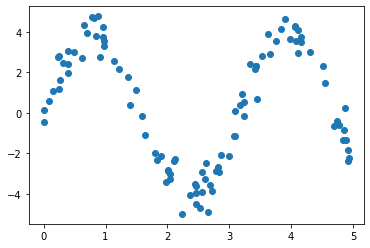

In [13]:
plt.plot(x_train.numpy(), y_train.numpy(), 'o')

## Normalizing Flows


\begin{align}
q(z') = q(z) \left| \mathrm{det} \frac{\partial f}{\partial z'} \right| = q(z) \left| \mathrm{det} \frac{\partial f}{\partial z} \right|^{-1}
\end{align}

\begin{align}
\ln q_K(z_K) = \ln q_0(z_0) - \sum_{k=1}^{K} \ln \left| \mathrm{det} \frac{\partial f_k}{\partial z_k} \right|
\end{align}

planar flow
\begin{align}
f(z) = z + uh(w^\top z + b)
\end{align}
\begin{align}
\mathrm{det} \left| \frac{\partial f}{\partial z} \right| = |\mathrm{det}(I + u\psi(z)^\top)| = |1 + u^\top \psi(z)|
\end{align}
\begin{align}
\psi(z) = h'(w^\top z + b)w
\end{align}

## module

In [0]:
class TensorLinearNet(TensorModule):
    def __init__(self):
        super(TensorLinearNet, self).__init__()
        n = 4
        self.linear1 = TensorLinear(1, n)
        self.linear2 = TensorLinear(n, n)
        self.linear3 = TensorLinear(n, n)
        self.linear4 = TensorLinear(n, n)

        self.last_layer = TensorLinear(n, 1)

        self.bn1 = TensorBatchNorm1d(n, affine=False)
        self.bn2 = TensorBatchNorm1d(n, affine=False)
        self.bn3 = TensorBatchNorm1d(n, affine=False)
        self.bn4 = TensorBatchNorm1d(n, affine=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.linear3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.linear4(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = self.last_layer(x)

        x1 = x
        x2 = None

        return x1, x2

## Variational Inference

$$
\begin{align}
& KL[q(W; \eta)||p(W|X, Y)] \\
&= \int q(W; \eta) \log \frac{q(W; \eta)}{p(W|X, Y)} dW\\
&= \int q(W; \eta) \log q(W; \eta)dW - \int q(W; \eta) \log \frac{p(Y|W, X)p(W)}{p(Y|X)}dW \\
&= \int q(W; \eta) \log q(W; \eta)dW - \int q(W; \eta) \log p(Y|W, X)dW - \int q(W; \eta) \log p(W)dW + const.\\
&= E[\log q(W; \eta)] - E[\log p(Y|W, X)] - E[\log p(W)] + const.
\end{align}
$$

\begin{align}
E[\log p(Y|W, X)] = E\left[\sum log p(y_i|W, x_i)\right]
\end{align}

In [0]:
def kl_divergence(q_w, p_w, loc_dict, model, x, y, idx):

    # sampling from q(w)
    zs = q_w.rsample()
    # z_0 = zs[0]
    w_sample = zs[-1]

    param_dict = transform_param(w_sample, loc_dict)
    model.set_params(param_dict)

    # calculate f(x)
    # p(y|x,w) = N(f(x; w), 1)
    out1, out2 = model(x)
    if out1.size(-1) != 1:
        raise ValueError

    p_y_xw = torchdist.Normal(out1, torch.ones_like(out1) / 2)
    # p_y_xw = torchdist.Normal(out1, out2)

    def temp(i):
        return min(1, 0.01 + i / 10000)

    # log(p(w, x, y)) = log(p(w)) + sum(log(p(y|x,w)))
    val_log_p_w = p_w.log_prob(w_sample).sum()
    val_log_p_y_xw = p_y_xw.log_prob(y).sum()
    val_log_q_w = q_w.log_prob(zs)
    # val_log_q_w = -q_w.entropy()

    if (idx + 1) % 100 == 0:
        out_desc = out1.detach()
        print('%d loss q(w) %f p(w) %f p(y|xw) %f min %f mean %f max %f'
              % (idx, val_log_q_w.item(), val_log_p_w.item(), val_log_p_y_xw.item(),
                 out_desc.min(), out_desc.mean(), out_desc.max()))

    # return val_log_q_w - temp(idx) * (val_log_p_w + val_log_p_y_xw)
    return val_log_q_w - (val_log_p_w + val_log_p_y_xw)
    # return val_log_q_w - val_log_p_y_xw
    # return - val_log_p_y_xw

def kl_divergence_nsamples(q_w, p_w, loc_dict, model, x, y, n_samples, idx):
    val_loss = 0    
    for _ in range(n_samples):
        val_loss += kl_divergence(q_w, p_w, loc_dict, model, x, y, idx) / n_samples
    return val_loss

def predict(q_w, loc_dict, model, x, n_samples):    
    
    approx_y = 0  
    # model.eval()
    with torch.no_grad():
        for i in range(n_samples):
            # sampling from q(w)
            w_sample = q_w.sample()[-1]

            param_dict = transform_param(w_sample, loc_dict)
            model.set_params(param_dict)
            # calculate f(x)
            out1, out2 = model(x)
            
            y_sample = out1

            approx_y += y_sample / n_samples
    
    return approx_y

def plt_prediction(q_w, loc_dict, model, x, y_true, n_smaples):
    y_pred = predict(q_w, loc_dict, model, x, n_smaples)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(x.numpy(), y_true.numpy(), 'o')
    axes[0].plot(x.numpy(), y_pred.numpy(), 'o')
    plt.show()

## exec

OrderedDict([('linear1.p_weight', {'size': torch.Size([4, 1]), 'loc': (0, 4)}), ('linear1.p_bias', {'size': torch.Size([4]), 'loc': (4, 8)}), ('linear2.p_weight', {'size': torch.Size([4, 4]), 'loc': (8, 24)}), ('linear2.p_bias', {'size': torch.Size([4]), 'loc': (24, 28)}), ('linear3.p_weight', {'size': torch.Size([4, 4]), 'loc': (28, 44)}), ('linear3.p_bias', {'size': torch.Size([4]), 'loc': (44, 48)}), ('linear4.p_weight', {'size': torch.Size([4, 4]), 'loc': (48, 64)}), ('linear4.p_bias', {'size': torch.Size([4]), 'loc': (64, 68)}), ('last_layer.p_weight', {'size': torch.Size([1, 4]), 'loc': (68, 72)}), ('last_layer.p_bias', {'size': torch.Size([1]), 'loc': (72, 73)})])
73
99 loss q(w) -93.097015 p(w) -237.416351 p(y|xw) -697.552551 min -3.542626 mean -0.233923 max 1.920116
99 loss q(w) -84.264702 p(w) -237.948242 p(y|xw) -424.329620 min -4.654944 mean 0.767720 max 5.746928
99 loss q(w) -99.583717 p(w) -238.056580 p(y|xw) -1258.827637 min -2.987861 mean 1.925178 max 5.780422
99 loss q

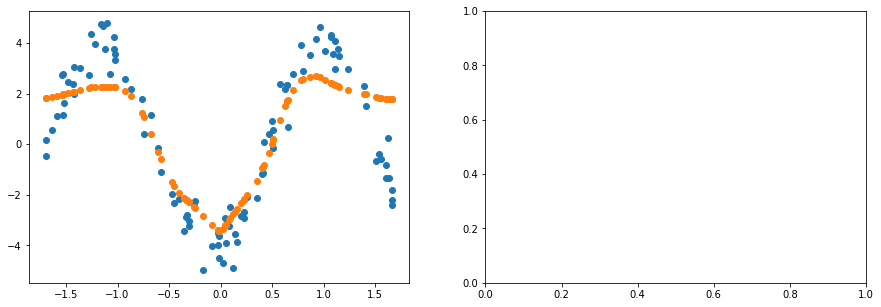

199 loss q(w) -84.356911 p(w) -238.914459 p(y|xw) -308.975830 min -4.083902 mean 0.196753 max 3.304840
199 loss q(w) -80.456871 p(w) -238.545746 p(y|xw) -212.229279 min -3.769398 mean 0.342782 max 3.786812
199 loss q(w) -98.931358 p(w) -239.260391 p(y|xw) -436.714386 min -3.447170 mean 1.038533 max 4.335689
199 loss q(w) -86.315063 p(w) -238.796707 p(y|xw) -556.220642 min -4.801238 mean 0.891683 max 6.278656
199 loss q(w) -83.429916 p(w) -239.385971 p(y|xw) -364.996399 min -3.517653 mean 0.938848 max 4.292819
199 loss q(w) -92.532562 p(w) -238.863190 p(y|xw) -194.178558 min -4.386316 mean 0.279790 max 4.270867
199 loss q(w) -97.235558 p(w) -238.962143 p(y|xw) -256.437592 min -3.428617 mean 0.722806 max 4.058430
199 loss q(w) -83.332977 p(w) -238.856827 p(y|xw) -250.269180 min -3.143125 mean 0.834133 max 4.260010
199 loss q(w) -100.703102 p(w) -238.690414 p(y|xw) -670.040955 min -3.194248 mean 1.655637 max 6.571117
199 loss q(w) -93.989395 p(w) -238.651245 p(y|xw) -366.892548 min -4.698

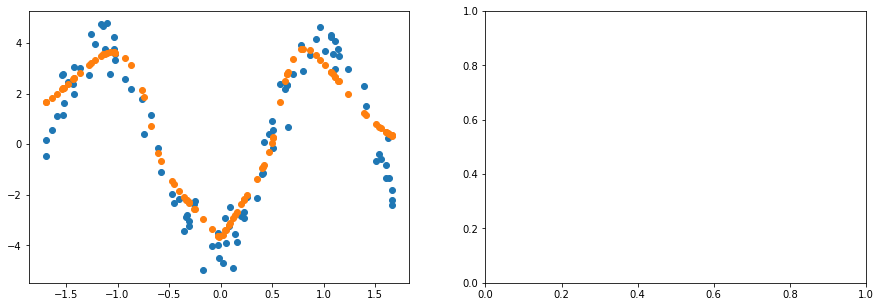

299 loss q(w) -88.388527 p(w) -239.311996 p(y|xw) -393.893524 min -3.631849 mean 0.144021 max 3.590480
299 loss q(w) -84.711639 p(w) -239.739410 p(y|xw) -238.901566 min -4.443423 mean 0.492276 max 3.321846
299 loss q(w) -95.057060 p(w) -239.267944 p(y|xw) -312.679108 min -3.347566 mean -0.088588 max 2.608546
299 loss q(w) -76.782867 p(w) -239.413696 p(y|xw) -289.904144 min -3.052784 mean 1.177576 max 4.828379
299 loss q(w) -81.200745 p(w) -239.742447 p(y|xw) -286.267120 min -3.105722 mean 0.506784 max 3.600043
299 loss q(w) -82.862221 p(w) -239.156281 p(y|xw) -248.105942 min -3.988729 mean 0.628623 max 3.829503
299 loss q(w) -95.388924 p(w) -239.427689 p(y|xw) -322.045807 min -3.302039 mean 0.417438 max 2.880151
299 loss q(w) -84.628075 p(w) -239.383667 p(y|xw) -239.086380 min -3.890088 mean 0.541334 max 4.398760
299 loss q(w) -89.004372 p(w) -239.006577 p(y|xw) -213.469147 min -4.678097 mean 0.304385 max 4.397767
299 loss q(w) -87.811089 p(w) -239.567261 p(y|xw) -331.928711 min -4.294

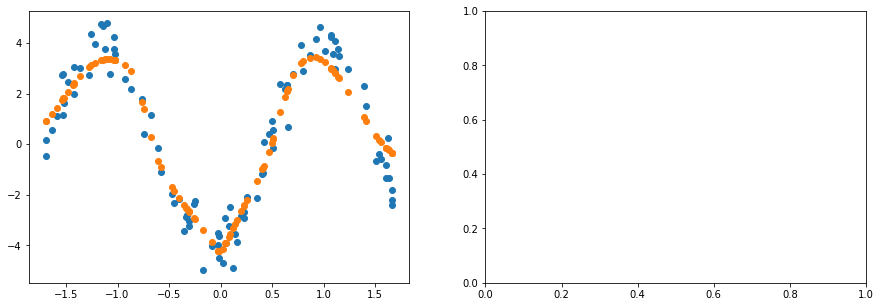

399 loss q(w) -86.454071 p(w) -240.277390 p(y|xw) -204.782333 min -3.765466 mean 0.568654 max 4.758287
399 loss q(w) -79.388939 p(w) -239.649261 p(y|xw) -202.427933 min -4.205248 mean 0.634776 max 4.613325
399 loss q(w) -85.245529 p(w) -240.088608 p(y|xw) -162.979248 min -4.659575 mean 0.463344 max 3.573448
399 loss q(w) -84.876564 p(w) -240.388809 p(y|xw) -165.945786 min -4.391008 mean 0.582038 max 4.075698
399 loss q(w) -88.158653 p(w) -240.240402 p(y|xw) -188.680603 min -4.412558 mean 0.139103 max 3.279237
399 loss q(w) -90.678474 p(w) -239.938950 p(y|xw) -193.631424 min -5.254220 mean -0.055949 max 3.123173
399 loss q(w) -99.337372 p(w) -238.410934 p(y|xw) -214.398758 min -4.116462 mean 0.335230 max 3.636684
399 loss q(w) -95.466728 p(w) -239.990555 p(y|xw) -158.639832 min -4.075005 mean 0.534270 max 4.077219
399 loss q(w) -88.858803 p(w) -240.901825 p(y|xw) -170.628571 min -4.707505 mean 0.639326 max 4.552879
399 loss q(w) -83.337067 p(w) -239.890320 p(y|xw) -262.646759 min -4.016

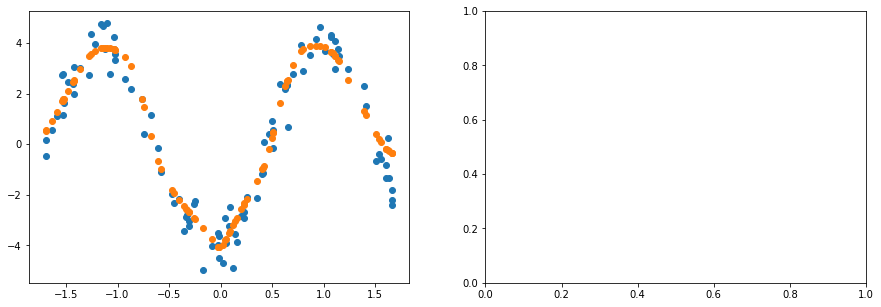

499 loss q(w) -85.913216 p(w) -240.970825 p(y|xw) -140.395416 min -4.768861 mean 0.171442 max 3.667699
499 loss q(w) -83.582542 p(w) -240.367523 p(y|xw) -137.893539 min -3.800427 mean 0.479674 max 3.915213
499 loss q(w) -82.088150 p(w) -240.482162 p(y|xw) -194.107132 min -4.555550 mean 0.321039 max 3.696399
499 loss q(w) -92.343048 p(w) -240.728439 p(y|xw) -181.535370 min -4.297944 mean 0.887426 max 4.370378
499 loss q(w) -78.540970 p(w) -240.047104 p(y|xw) -174.662628 min -4.001356 mean 0.815168 max 4.817481
499 loss q(w) -87.561378 p(w) -240.420792 p(y|xw) -166.207275 min -3.781651 mean 0.636817 max 4.170835
499 loss q(w) -89.216896 p(w) -240.554749 p(y|xw) -207.459045 min -4.398265 mean 0.489058 max 3.908659
499 loss q(w) -83.929008 p(w) -240.506897 p(y|xw) -172.212769 min -4.256176 mean 0.048634 max 3.111647
499 loss q(w) -95.388817 p(w) -239.887619 p(y|xw) -213.030640 min -4.178743 mean 0.531811 max 3.548242
499 loss q(w) -78.146416 p(w) -240.328049 p(y|xw) -258.531494 min -4.5792

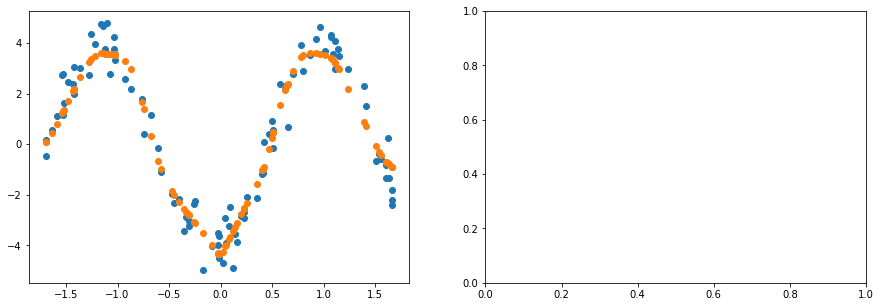

599 loss q(w) -96.856499 p(w) -239.021454 p(y|xw) -998.778564 min -4.406770 mean 0.572477 max 3.519908
599 loss q(w) -84.049126 p(w) -240.635239 p(y|xw) -150.662125 min -3.771268 mean 0.315008 max 3.750444
599 loss q(w) -89.171730 p(w) -240.054947 p(y|xw) -152.195358 min -4.476796 mean 0.644711 max 4.314368
599 loss q(w) -76.747467 p(w) -240.532700 p(y|xw) -143.472153 min -4.701615 mean 0.133914 max 3.454826
599 loss q(w) -80.160446 p(w) -240.512924 p(y|xw) -136.351074 min -4.255594 mean 0.315820 max 3.922504
599 loss q(w) -86.091156 p(w) -241.013840 p(y|xw) -253.645370 min -4.275458 mean 0.670763 max 3.707544
599 loss q(w) -85.987892 p(w) -240.499939 p(y|xw) -228.413071 min -3.931503 mean 0.121198 max 4.468077
599 loss q(w) -81.465454 p(w) -240.686890 p(y|xw) -208.781784 min -3.987198 mean 0.226461 max 3.570620
599 loss q(w) -87.205711 p(w) -241.095963 p(y|xw) -191.268021 min -4.849940 mean -0.021062 max 3.417674
599 loss q(w) -100.067467 p(w) -240.378952 p(y|xw) -239.996765 min -3.36

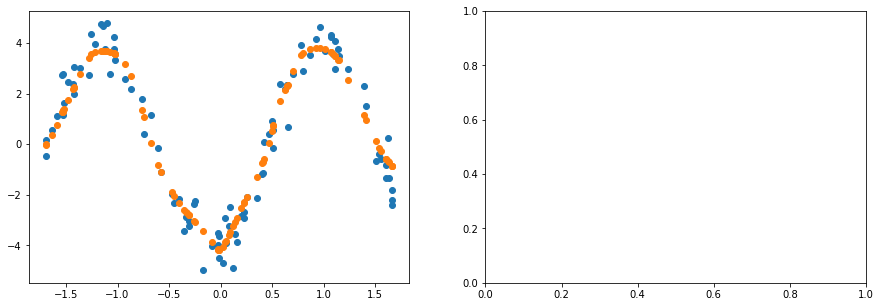

699 loss q(w) -91.689354 p(w) -241.615784 p(y|xw) -116.245155 min -4.463535 mean 0.461346 max 4.129099
699 loss q(w) -94.381187 p(w) -240.752563 p(y|xw) -156.820267 min -3.635345 mean 0.482482 max 3.563126
699 loss q(w) -83.647118 p(w) -241.167770 p(y|xw) -137.118484 min -4.307436 mean 0.461914 max 3.824680
699 loss q(w) -82.996239 p(w) -241.747787 p(y|xw) -167.535522 min -4.650349 mean 0.072078 max 3.269790
699 loss q(w) -84.814713 p(w) -240.671432 p(y|xw) -150.802322 min -4.012586 mean 0.245553 max 3.472116
699 loss q(w) -69.546898 p(w) -241.048233 p(y|xw) -132.905380 min -4.383839 mean 0.319753 max 4.352256
699 loss q(w) -97.267128 p(w) -240.968063 p(y|xw) -189.879623 min -4.032902 mean 0.168388 max 4.469963
699 loss q(w) -86.201721 p(w) -240.956680 p(y|xw) -125.391068 min -4.207909 mean 0.549991 max 4.051388
699 loss q(w) -80.087524 p(w) -241.068161 p(y|xw) -382.344727 min -4.738754 mean 0.284534 max 4.294259
699 loss q(w) -79.797585 p(w) -240.241119 p(y|xw) -215.563477 min -4.8683

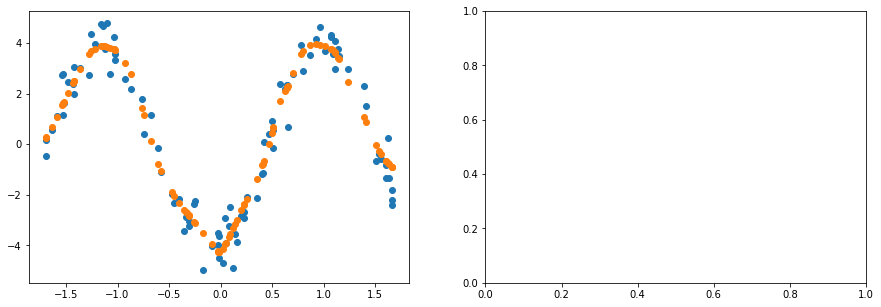

799 loss q(w) -71.991104 p(w) -241.067719 p(y|xw) -166.331436 min -4.314943 mean 0.342644 max 3.432280
799 loss q(w) -85.713181 p(w) -241.003754 p(y|xw) -207.825333 min -3.924191 mean 0.526020 max 5.357782
799 loss q(w) -78.935944 p(w) -241.089127 p(y|xw) -276.462921 min -3.315595 mean 1.157406 max 5.559667
799 loss q(w) -98.857780 p(w) -241.430130 p(y|xw) -159.868408 min -3.979901 mean 0.333419 max 3.631960
799 loss q(w) -88.091660 p(w) -241.341476 p(y|xw) -134.789932 min -3.742365 mean 0.475209 max 4.497408
799 loss q(w) -86.355057 p(w) -241.111084 p(y|xw) -143.634262 min -3.915292 mean 0.617572 max 3.941172
799 loss q(w) -84.341080 p(w) -241.710785 p(y|xw) -136.424606 min -4.678204 mean 0.242902 max 3.756449
799 loss q(w) -86.835976 p(w) -241.340454 p(y|xw) -161.477509 min -4.204825 mean 0.060188 max 2.898979
799 loss q(w) -86.341835 p(w) -241.344910 p(y|xw) -114.752586 min -4.633125 mean 0.203973 max 3.809597
799 loss q(w) -90.864693 p(w) -240.971527 p(y|xw) -168.734589 min -4.1387

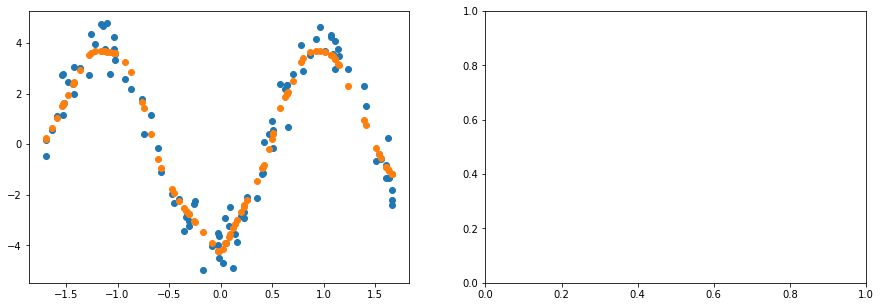

899 loss q(w) -82.663727 p(w) -241.048050 p(y|xw) -119.414108 min -4.387655 mean 0.320000 max 4.251143
899 loss q(w) -79.144043 p(w) -241.220764 p(y|xw) -126.841255 min -4.158964 mean 0.369613 max 4.384923
899 loss q(w) -83.516846 p(w) -241.357376 p(y|xw) -107.373192 min -4.423147 mean 0.247871 max 3.856026
899 loss q(w) -94.474777 p(w) -241.718292 p(y|xw) -178.092010 min -4.644434 mean 0.366575 max 4.215700
899 loss q(w) -79.559280 p(w) -241.396057 p(y|xw) -118.480629 min -4.014408 mean 0.401669 max 3.893267
899 loss q(w) -84.074715 p(w) -241.325729 p(y|xw) -124.027298 min -3.867377 mean 0.589666 max 4.577459
899 loss q(w) -89.224098 p(w) -242.034470 p(y|xw) -198.031967 min -4.399681 mean 0.345432 max 3.944489
899 loss q(w) -82.848167 p(w) -241.508026 p(y|xw) -142.769485 min -3.936189 mean 0.635401 max 4.682354
899 loss q(w) -70.033714 p(w) -241.147705 p(y|xw) -134.488708 min -4.341465 mean 0.195299 max 3.817922
899 loss q(w) -91.240150 p(w) -241.715195 p(y|xw) -137.700500 min -4.0715

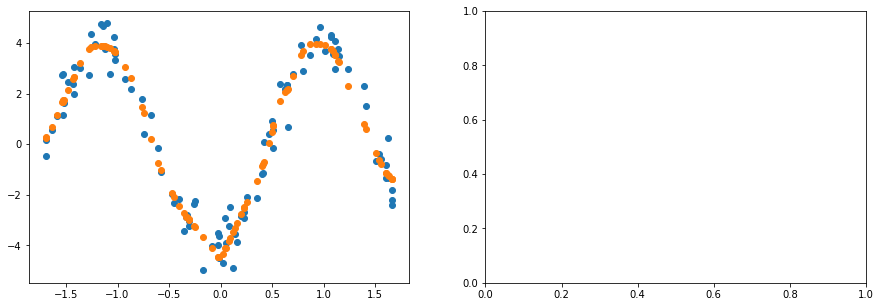

999 loss q(w) -67.299126 p(w) -241.391861 p(y|xw) -116.637863 min -4.115539 mean 0.382653 max 3.677224
999 loss q(w) -85.194870 p(w) -241.609879 p(y|xw) -163.314346 min -4.743234 mean 0.422465 max 4.020442
999 loss q(w) -89.489891 p(w) -241.392700 p(y|xw) -160.168076 min -4.819321 mean 0.476845 max 4.445525
999 loss q(w) -83.854858 p(w) -241.609558 p(y|xw) -169.191406 min -4.035039 mean 0.536705 max 4.516761
999 loss q(w) -78.153198 p(w) -241.860077 p(y|xw) -146.071884 min -4.126567 mean 0.260273 max 3.530748
999 loss q(w) -73.076073 p(w) -241.593704 p(y|xw) -128.681076 min -4.394697 mean 0.455866 max 4.365757
999 loss q(w) -84.341309 p(w) -241.881989 p(y|xw) -195.522293 min -3.886129 mean 0.510161 max 3.460804
999 loss q(w) -89.518623 p(w) -241.618286 p(y|xw) -158.999039 min -4.262385 mean 0.178281 max 3.879100
999 loss q(w) -79.210670 p(w) -241.364929 p(y|xw) -124.991257 min -4.487224 mean 0.540077 max 4.577102
999 loss q(w) -72.255600 p(w) -241.315308 p(y|xw) -106.059143 min -4.3996

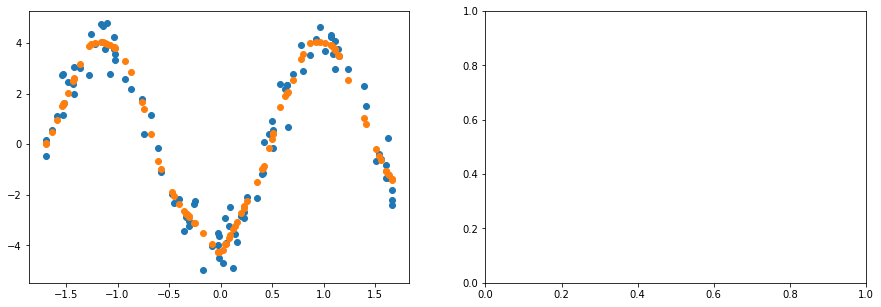

1099 loss q(w) -72.191193 p(w) -241.460556 p(y|xw) -129.053101 min -4.478139 mean 0.291507 max 3.746414
1099 loss q(w) -85.679924 p(w) -241.580597 p(y|xw) -133.457825 min -4.416912 mean 0.422772 max 4.465806
1099 loss q(w) -83.654266 p(w) -241.449112 p(y|xw) -135.538361 min -4.129780 mean 0.543219 max 4.204759
1099 loss q(w) -87.496742 p(w) -242.296356 p(y|xw) -131.782501 min -4.472590 mean 0.107853 max 3.563319
1099 loss q(w) -86.347527 p(w) -241.698776 p(y|xw) -176.137222 min -4.257400 mean 0.209651 max 3.687860
1099 loss q(w) -73.547607 p(w) -241.893723 p(y|xw) -108.873077 min -3.970608 mean 0.423811 max 4.247704
1099 loss q(w) -81.289589 p(w) -241.570847 p(y|xw) -110.231453 min -3.981112 mean 0.447528 max 3.860757
1099 loss q(w) -77.345070 p(w) -241.947296 p(y|xw) -138.331970 min -4.482674 mean 0.634761 max 4.249200
1099 loss q(w) -92.628288 p(w) -242.360687 p(y|xw) -123.718033 min -4.569164 mean 0.621463 max 4.474589
1099 loss q(w) -90.041649 p(w) -241.607056 p(y|xw) -121.666931 m

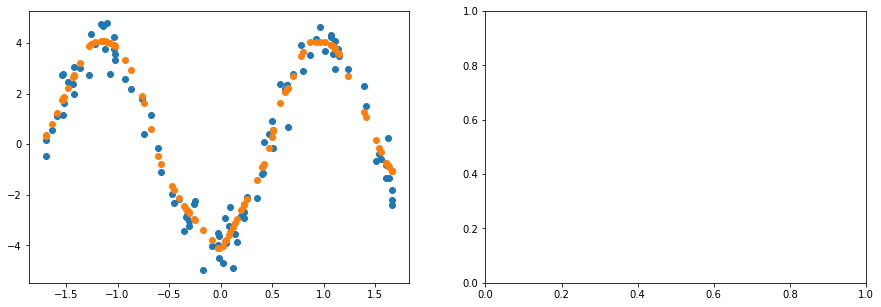

1199 loss q(w) -75.355919 p(w) -241.858673 p(y|xw) -115.907043 min -3.888459 mean 0.494094 max 3.826906
1199 loss q(w) -85.385902 p(w) -241.685150 p(y|xw) -164.460938 min -5.110909 mean 0.451528 max 3.942731
1199 loss q(w) -71.986404 p(w) -241.768829 p(y|xw) -140.996033 min -3.914009 mean 0.525521 max 3.671171
1199 loss q(w) -81.593468 p(w) -241.922745 p(y|xw) -122.078621 min -4.266781 mean 0.707114 max 4.063702
1199 loss q(w) -81.847252 p(w) -241.505234 p(y|xw) -144.347794 min -3.973930 mean 0.085672 max 3.272638
1199 loss q(w) -84.130005 p(w) -242.276108 p(y|xw) -150.393967 min -4.650718 mean 0.411643 max 3.916044
1199 loss q(w) -89.903885 p(w) -241.918747 p(y|xw) -122.672539 min -3.849339 mean 0.445733 max 3.901581
1199 loss q(w) -87.613907 p(w) -241.327515 p(y|xw) -128.883392 min -3.989848 mean 0.627977 max 4.078099
1199 loss q(w) -72.288094 p(w) -241.703415 p(y|xw) -162.000610 min -4.244136 mean 0.574246 max 4.402899
1199 loss q(w) -71.173058 p(w) -241.154999 p(y|xw) -140.694519 m

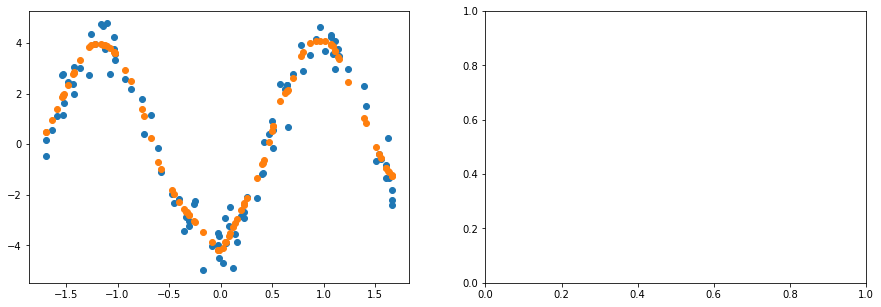

1299 loss q(w) -77.358429 p(w) -242.447586 p(y|xw) -110.480331 min -4.295513 mean 0.298234 max 3.766027
1299 loss q(w) -78.447624 p(w) -241.642715 p(y|xw) -135.250198 min -4.419448 mean 0.487872 max 3.996624
1299 loss q(w) -82.376511 p(w) -242.166306 p(y|xw) -124.647163 min -3.977258 mean 0.647269 max 4.398520
1299 loss q(w) -81.185890 p(w) -242.053696 p(y|xw) -118.358315 min -4.075063 mean 0.455001 max 4.553866
1299 loss q(w) -83.080238 p(w) -242.447815 p(y|xw) -110.227501 min -3.868988 mean 0.480006 max 3.975390
1299 loss q(w) -83.132668 p(w) -241.989914 p(y|xw) -141.042297 min -4.005600 mean 0.413300 max 4.136947
1299 loss q(w) -76.360863 p(w) -242.436783 p(y|xw) -123.579193 min -4.288130 mean 0.424897 max 4.072516
1299 loss q(w) -78.089241 p(w) -242.557114 p(y|xw) -109.353256 min -3.809607 mean 0.513916 max 4.085105
1299 loss q(w) -84.611519 p(w) -241.612930 p(y|xw) -156.163635 min -4.287269 mean 0.048510 max 3.767231
1299 loss q(w) -83.056511 p(w) -242.156097 p(y|xw) -122.887749 m

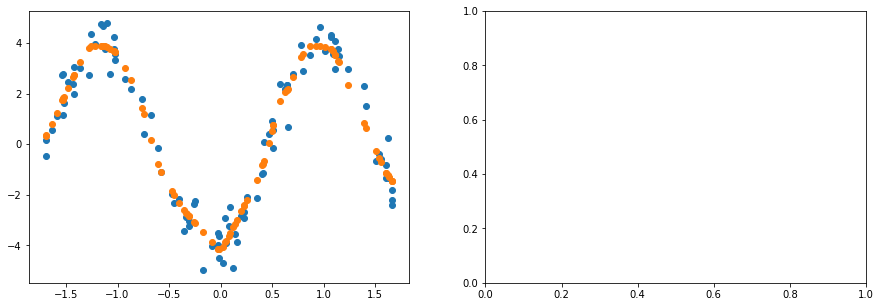

1399 loss q(w) -81.657677 p(w) -242.355728 p(y|xw) -135.689651 min -3.980264 mean 0.526860 max 4.577449
1399 loss q(w) -84.371391 p(w) -242.464737 p(y|xw) -140.543686 min -4.028828 mean 0.343691 max 3.670980
1399 loss q(w) -72.979485 p(w) -242.246933 p(y|xw) -114.645493 min -3.809395 mean 0.436638 max 4.095666
1399 loss q(w) -75.724930 p(w) -241.511246 p(y|xw) -131.591583 min -4.225136 mean 0.242230 max 3.633620
1399 loss q(w) -84.466278 p(w) -242.309158 p(y|xw) -122.962494 min -4.326902 mean 0.566733 max 4.429332
1399 loss q(w) -76.941818 p(w) -241.797714 p(y|xw) -116.162422 min -4.227881 mean 0.312959 max 3.705050
1399 loss q(w) -72.946907 p(w) -242.732376 p(y|xw) -116.040825 min -4.395522 mean 0.366737 max 3.753569
1399 loss q(w) -76.545868 p(w) -242.081284 p(y|xw) -121.977333 min -4.465178 mean 0.634809 max 4.462733
1399 loss q(w) -83.486427 p(w) -242.809143 p(y|xw) -115.734131 min -4.328472 mean 0.429956 max 4.203943
1399 loss q(w) -71.848267 p(w) -242.735428 p(y|xw) -104.202957 m

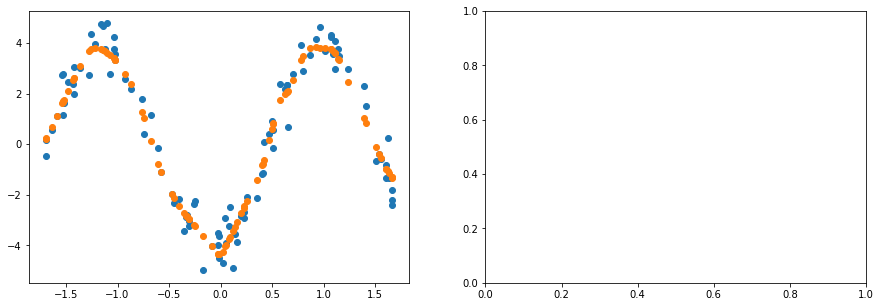

1499 loss q(w) -78.870750 p(w) -242.289001 p(y|xw) -131.039612 min -3.798693 mean 0.732469 max 4.950262
1499 loss q(w) -86.181564 p(w) -242.744308 p(y|xw) -147.696777 min -3.664156 mean 0.584443 max 3.759079
1499 loss q(w) -82.550621 p(w) -242.566406 p(y|xw) -122.353874 min -4.612159 mean 0.328616 max 3.631623
1499 loss q(w) -93.253769 p(w) -243.249557 p(y|xw) -133.555344 min -4.429532 mean 0.736114 max 4.413065
1499 loss q(w) -77.044464 p(w) -242.076859 p(y|xw) -114.717369 min -4.156303 mean 0.216337 max 3.620446
1499 loss q(w) -75.054070 p(w) -242.430145 p(y|xw) -122.011200 min -3.888393 mean 0.381567 max 4.119839
1499 loss q(w) -80.685211 p(w) -242.464722 p(y|xw) -116.501244 min -4.147568 mean 0.207934 max 3.801748
1499 loss q(w) -79.746178 p(w) -242.238770 p(y|xw) -127.231842 min -3.698918 mean 0.390764 max 4.178823
1499 loss q(w) -75.808853 p(w) -242.318253 p(y|xw) -125.253769 min -4.564806 mean 0.545768 max 4.055922
1499 loss q(w) -73.582985 p(w) -242.161697 p(y|xw) -117.962402 m

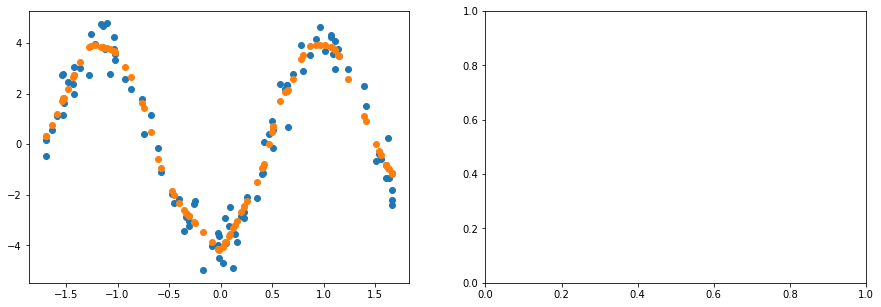

1599 loss q(w) -79.979889 p(w) -242.710876 p(y|xw) -142.998489 min -3.524019 mean 0.545749 max 4.127813
1599 loss q(w) -75.236572 p(w) -242.346909 p(y|xw) -153.668777 min -4.700585 mean 0.673090 max 4.429454
1599 loss q(w) -78.240204 p(w) -242.199615 p(y|xw) -136.966660 min -4.008372 mean 0.551147 max 4.178668
1599 loss q(w) -71.537857 p(w) -242.174301 p(y|xw) -113.584793 min -4.848016 mean 0.237555 max 3.699757
1599 loss q(w) -73.303963 p(w) -242.051544 p(y|xw) -151.963394 min -4.092367 mean 0.546173 max 4.077596
1599 loss q(w) -80.323830 p(w) -242.058578 p(y|xw) -107.836121 min -3.874261 mean 0.372599 max 3.874858
1599 loss q(w) -85.961014 p(w) -241.885223 p(y|xw) -117.216789 min -4.241190 mean 0.432275 max 4.270839
1599 loss q(w) -84.462563 p(w) -242.426102 p(y|xw) -155.530136 min -3.737725 mean 0.350722 max 3.599645
1599 loss q(w) -85.805336 p(w) -242.535416 p(y|xw) -104.538155 min -4.322623 mean 0.248253 max 3.953901
1599 loss q(w) -83.812820 p(w) -242.679108 p(y|xw) -148.247116 m

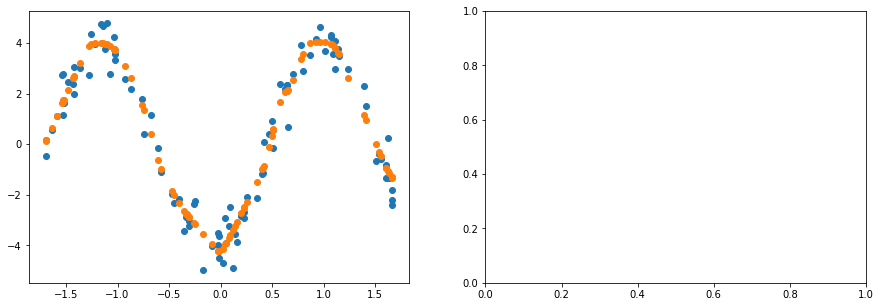

1699 loss q(w) -77.524605 p(w) -242.491821 p(y|xw) -114.641319 min -4.105834 mean 0.445347 max 3.895242
1699 loss q(w) -75.530418 p(w) -242.231476 p(y|xw) -112.758911 min -4.323121 mean 0.284984 max 3.806629
1699 loss q(w) -82.900291 p(w) -242.561340 p(y|xw) -136.429276 min -4.396118 mean 0.118820 max 3.247499
1699 loss q(w) -80.906120 p(w) -242.075790 p(y|xw) -116.983635 min -3.559732 mean 0.606899 max 4.119756
1699 loss q(w) -93.404579 p(w) -242.732513 p(y|xw) -149.141708 min -4.176104 mean 0.361078 max 3.978554
1699 loss q(w) -89.391396 p(w) -242.662399 p(y|xw) -137.744507 min -4.143581 mean 0.507084 max 4.603974
1699 loss q(w) -90.275391 p(w) -242.609390 p(y|xw) -123.673157 min -3.918717 mean 0.299352 max 3.498486
1699 loss q(w) -76.849236 p(w) -243.341141 p(y|xw) -104.912560 min -4.089131 mean 0.424096 max 3.918698
1699 loss q(w) -85.265373 p(w) -242.496979 p(y|xw) -109.767334 min -4.264878 mean 0.515827 max 4.013609
1699 loss q(w) -79.463249 p(w) -242.584747 p(y|xw) -131.932587 m

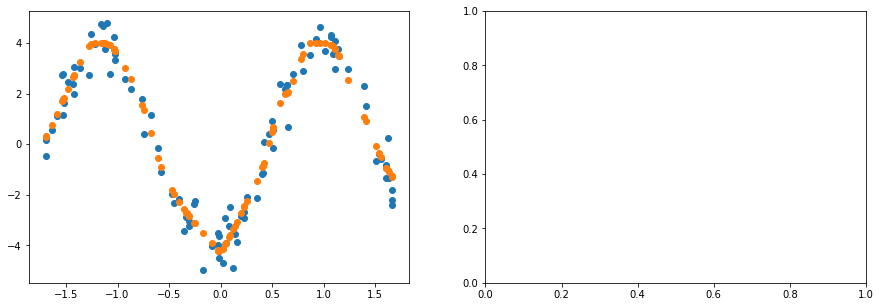

1799 loss q(w) -82.972115 p(w) -243.478989 p(y|xw) -121.138367 min -3.573412 mean 0.602648 max 4.192627
1799 loss q(w) -82.711502 p(w) -243.596085 p(y|xw) -119.297043 min -4.361524 mean 0.389234 max 4.495492
1799 loss q(w) -73.179497 p(w) -242.664368 p(y|xw) -115.245583 min -4.098033 mean 0.303801 max 3.872879
1799 loss q(w) -73.319817 p(w) -242.923935 p(y|xw) -116.240814 min -4.116068 mean 0.354384 max 3.655736
1799 loss q(w) -80.933289 p(w) -242.480042 p(y|xw) -111.983429 min -3.953524 mean 0.281749 max 3.743074
1799 loss q(w) -80.226585 p(w) -242.819107 p(y|xw) -144.243347 min -3.903258 mean 0.535034 max 3.942476
1799 loss q(w) -84.174057 p(w) -242.626434 p(y|xw) -126.355919 min -4.224348 mean 0.450825 max 4.046770
1799 loss q(w) -85.183495 p(w) -242.062073 p(y|xw) -137.614960 min -3.565716 mean 0.368884 max 4.155900
1799 loss q(w) -83.286201 p(w) -243.178406 p(y|xw) -127.927788 min -4.586217 mean 0.433396 max 4.398757
1799 loss q(w) -84.925949 p(w) -243.419052 p(y|xw) -123.200493 m

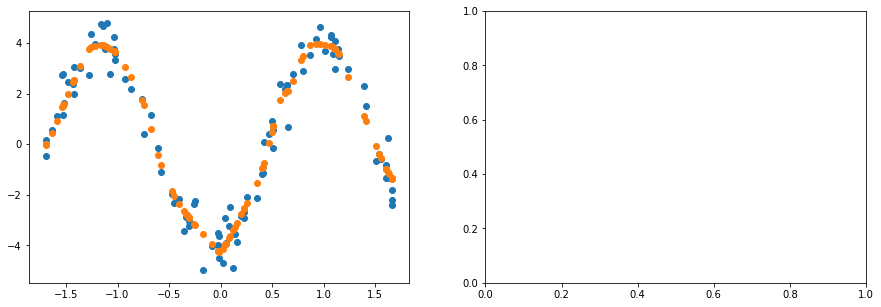

1899 loss q(w) -71.329071 p(w) -243.292313 p(y|xw) -139.951782 min -3.358658 mean 0.662350 max 4.485153
1899 loss q(w) -73.682274 p(w) -242.623154 p(y|xw) -122.143425 min -4.003200 mean 0.382476 max 3.724344
1899 loss q(w) -95.956833 p(w) -242.253860 p(y|xw) -150.880630 min -4.434222 mean 0.326926 max 4.148415
1899 loss q(w) -74.778015 p(w) -242.588196 p(y|xw) -111.870872 min -4.176594 mean 0.586060 max 4.363276
1899 loss q(w) -77.133766 p(w) -242.272675 p(y|xw) -160.154770 min -4.087110 mean 0.476760 max 5.041204
1899 loss q(w) -93.271988 p(w) -243.709366 p(y|xw) -211.735016 min -4.258197 mean 0.828102 max 4.376382
1899 loss q(w) -82.558960 p(w) -242.946732 p(y|xw) -128.363037 min -3.698769 mean 0.703108 max 4.854357
1899 loss q(w) -86.585838 p(w) -242.976852 p(y|xw) -127.753426 min -4.512420 mean 0.501352 max 3.912110
1899 loss q(w) -90.266747 p(w) -242.995392 p(y|xw) -117.472282 min -4.684000 mean 0.136815 max 3.788970
1899 loss q(w) -75.828911 p(w) -242.424973 p(y|xw) -122.490204 m

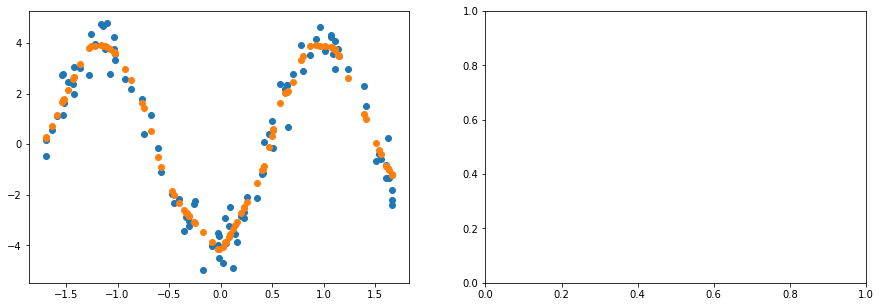

1999 loss q(w) -93.552589 p(w) -243.289688 p(y|xw) -171.232666 min -5.065161 mean -0.096321 max 3.738242
1999 loss q(w) -74.566559 p(w) -242.691406 p(y|xw) -136.734512 min -4.867694 mean 0.128481 max 3.254077
1999 loss q(w) -75.050949 p(w) -243.283951 p(y|xw) -132.566544 min -4.278409 mean 0.231721 max 3.716916
1999 loss q(w) -76.095421 p(w) -243.423996 p(y|xw) -164.828918 min -4.670687 mean 0.019409 max 3.238726
1999 loss q(w) -77.925804 p(w) -242.654297 p(y|xw) -137.251389 min -3.904405 mean 0.155767 max 3.580658
1999 loss q(w) -78.421616 p(w) -242.304062 p(y|xw) -108.255402 min -4.234334 mean 0.378632 max 4.385527
1999 loss q(w) -76.909996 p(w) -243.462646 p(y|xw) -148.064560 min -4.188376 mean 0.329866 max 3.744118
1999 loss q(w) -70.092812 p(w) -243.016129 p(y|xw) -113.695038 min -4.477762 mean 0.544576 max 4.257355
1999 loss q(w) -90.116898 p(w) -243.082733 p(y|xw) -121.890633 min -4.194989 mean 0.176683 max 3.396826
1999 loss q(w) -79.125847 p(w) -243.057755 p(y|xw) -110.768280 

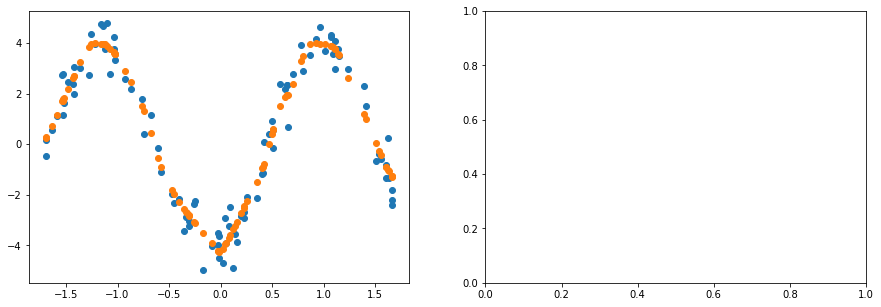

2099 loss q(w) -84.719734 p(w) -243.707809 p(y|xw) -117.159195 min -4.523167 mean 0.374176 max 4.216038
2099 loss q(w) -98.847137 p(w) -243.629822 p(y|xw) -177.240738 min -4.716571 mean 0.360432 max 4.256847
2099 loss q(w) -75.991150 p(w) -243.377121 p(y|xw) -109.101479 min -4.410699 mean 0.259746 max 3.766006
2099 loss q(w) -80.073570 p(w) -242.802795 p(y|xw) -144.873413 min -4.374819 mean 0.311766 max 3.830242
2099 loss q(w) -83.611580 p(w) -242.997742 p(y|xw) -126.453880 min -3.611692 mean 0.650756 max 4.353739
2099 loss q(w) -74.637268 p(w) -243.252197 p(y|xw) -110.547325 min -4.149218 mean 0.533631 max 4.304922
2099 loss q(w) -82.025528 p(w) -243.133682 p(y|xw) -104.954987 min -3.932005 mean 0.501803 max 3.894497
2099 loss q(w) -79.058037 p(w) -243.371597 p(y|xw) -129.337280 min -3.869545 mean 0.413088 max 4.357044
2099 loss q(w) -77.738564 p(w) -243.631088 p(y|xw) -124.023674 min -3.518656 mean 0.298929 max 3.358372
2099 loss q(w) -75.243065 p(w) -243.215408 p(y|xw) -169.306229 m

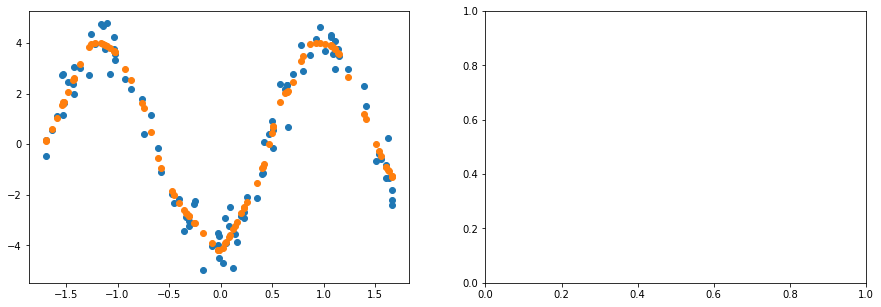

2199 loss q(w) -82.616982 p(w) -243.962051 p(y|xw) -119.921043 min -4.261576 mean 0.220489 max 3.729356
2199 loss q(w) -76.800430 p(w) -243.276260 p(y|xw) -120.128052 min -4.497721 mean 0.248690 max 4.542396
2199 loss q(w) -72.576675 p(w) -243.059418 p(y|xw) -103.774757 min -3.967800 mean 0.406313 max 3.819726
2199 loss q(w) -82.907341 p(w) -243.155914 p(y|xw) -128.545059 min -3.706470 mean 0.376396 max 3.909365
2199 loss q(w) -77.027336 p(w) -242.749512 p(y|xw) -115.840027 min -4.136577 mean 0.348653 max 4.772672
2199 loss q(w) -76.960243 p(w) -243.547272 p(y|xw) -113.305588 min -4.454605 mean 0.270987 max 4.062876
2199 loss q(w) -75.788483 p(w) -243.233398 p(y|xw) -110.861511 min -4.519465 mean 0.368563 max 4.110338
2199 loss q(w) -79.522728 p(w) -243.164658 p(y|xw) -129.701233 min -4.229114 mean 0.509684 max 4.260811
2199 loss q(w) -77.142914 p(w) -243.588272 p(y|xw) -104.440056 min -4.225958 mean 0.248333 max 3.892389
2199 loss q(w) -77.691345 p(w) -243.397568 p(y|xw) -107.675346 m

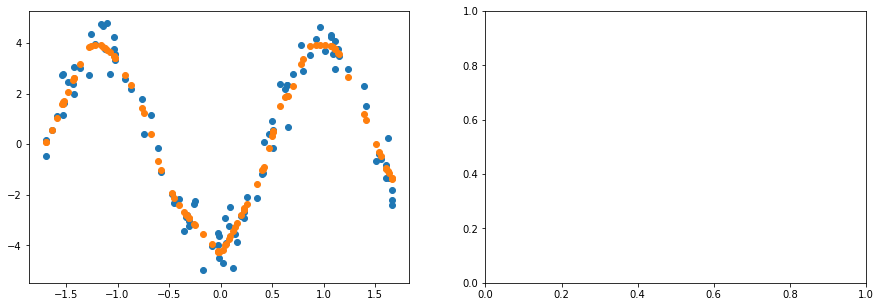

2299 loss q(w) -74.614403 p(w) -243.367386 p(y|xw) -104.637321 min -4.283250 mean 0.512067 max 3.942048
2299 loss q(w) -73.480232 p(w) -242.772018 p(y|xw) -165.038086 min -3.675311 mean 0.603897 max 3.989106
2299 loss q(w) -92.085014 p(w) -243.264465 p(y|xw) -115.839111 min -4.394922 mean 0.402073 max 4.084228
2299 loss q(w) -76.992516 p(w) -243.782745 p(y|xw) -121.171455 min -4.572130 mean 0.520965 max 4.087729
2299 loss q(w) -77.432571 p(w) -243.660065 p(y|xw) -111.061768 min -3.919103 mean 0.375941 max 3.551615
2299 loss q(w) -73.686615 p(w) -243.289551 p(y|xw) -135.705750 min -3.237343 mean 0.522512 max 3.948112
2299 loss q(w) -82.986504 p(w) -243.212311 p(y|xw) -102.590714 min -4.313444 mean 0.309466 max 4.062333
2299 loss q(w) -80.960304 p(w) -243.812073 p(y|xw) -129.641174 min -3.739793 mean 0.627701 max 4.118275
2299 loss q(w) -76.712364 p(w) -243.287445 p(y|xw) -118.544334 min -4.409800 mean 0.599523 max 4.624870
2299 loss q(w) -97.503723 p(w) -243.543457 p(y|xw) -150.286057 m

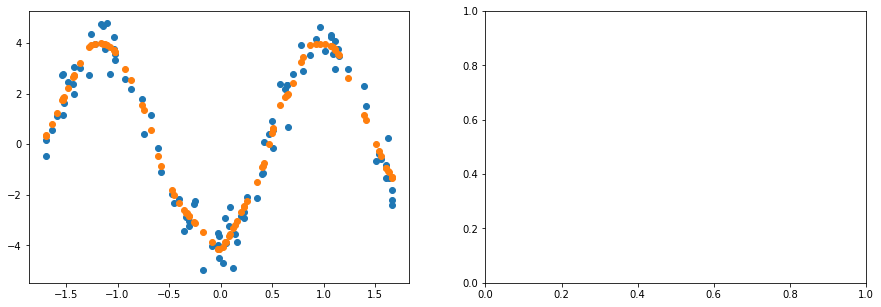

2399 loss q(w) -77.012024 p(w) -243.675003 p(y|xw) -107.171463 min -3.885212 mean 0.425872 max 3.890605
2399 loss q(w) -66.925087 p(w) -243.530548 p(y|xw) -104.308281 min -3.919348 mean 0.537139 max 4.148135
2399 loss q(w) -79.206062 p(w) -243.763336 p(y|xw) -118.632797 min -4.002036 mean 0.335181 max 3.523000
2399 loss q(w) -79.562546 p(w) -243.269043 p(y|xw) -113.661499 min -4.659217 mean 0.503082 max 4.419854
2399 loss q(w) -85.452179 p(w) -242.738037 p(y|xw) -115.013977 min -4.792137 mean 0.193260 max 3.951157
2399 loss q(w) -79.237862 p(w) -243.793350 p(y|xw) -125.849678 min -3.651475 mean 0.638260 max 4.509782
2399 loss q(w) -82.685120 p(w) -243.903214 p(y|xw) -111.302597 min -4.329069 mean 0.518425 max 3.763968
2399 loss q(w) -83.087067 p(w) -243.721420 p(y|xw) -113.135208 min -3.657538 mean 0.624540 max 4.563983
2399 loss q(w) -92.221497 p(w) -243.673889 p(y|xw) -119.802811 min -4.311864 mean 0.336270 max 4.185890
2399 loss q(w) -86.149811 p(w) -243.690918 p(y|xw) -126.262299 m

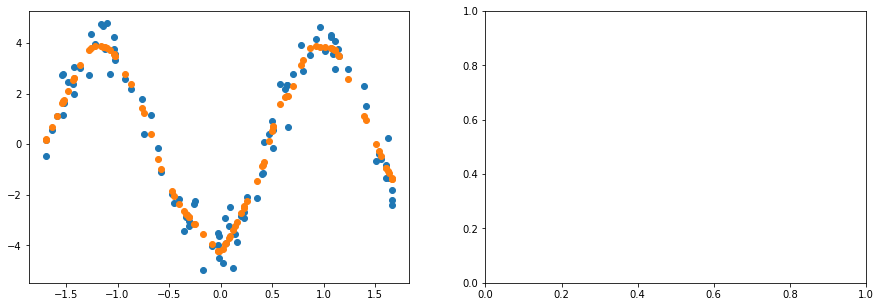

2499 loss q(w) -79.727264 p(w) -243.731613 p(y|xw) -104.127487 min -4.479817 mean 0.380476 max 4.240062
2499 loss q(w) -73.738297 p(w) -243.223541 p(y|xw) -107.615036 min -4.102287 mean 0.209959 max 3.579084
2499 loss q(w) -78.443420 p(w) -243.809677 p(y|xw) -121.362358 min -4.142012 mean 0.198302 max 3.902729
2499 loss q(w) -99.570480 p(w) -243.624481 p(y|xw) -104.074013 min -3.964997 mean 0.312911 max 4.192891
2499 loss q(w) -93.296417 p(w) -243.399475 p(y|xw) -111.852371 min -3.724792 mean 0.550337 max 3.928517
2499 loss q(w) -70.322784 p(w) -243.569595 p(y|xw) -109.115875 min -3.569571 mean 0.620139 max 3.915034
2499 loss q(w) -72.562134 p(w) -243.987305 p(y|xw) -140.966812 min -4.183475 mean 0.496266 max 4.337770
2499 loss q(w) -88.324966 p(w) -243.517410 p(y|xw) -190.710632 min -4.228543 mean 0.570856 max 4.093686
2499 loss q(w) -86.806602 p(w) -243.569855 p(y|xw) -107.194946 min -4.250179 mean 0.398237 max 3.984319
2499 loss q(w) -90.266716 p(w) -243.901505 p(y|xw) -200.154846 m

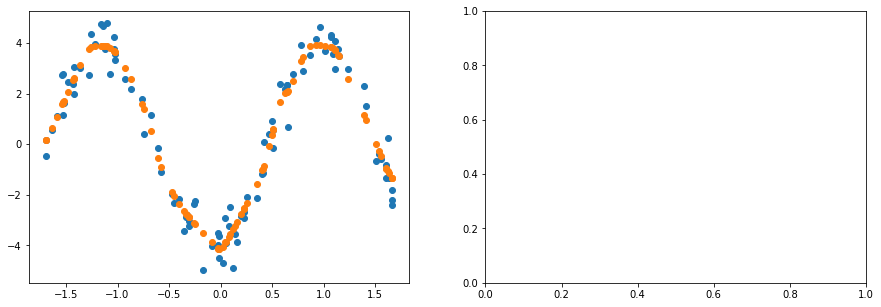

2599 loss q(w) -77.711136 p(w) -243.462387 p(y|xw) -96.549782 min -3.977365 mean 0.491517 max 4.129997
2599 loss q(w) -96.703812 p(w) -243.824005 p(y|xw) -106.260895 min -4.188908 mean 0.480485 max 4.456936
2599 loss q(w) -82.205704 p(w) -242.843445 p(y|xw) -100.396736 min -4.197295 mean 0.482742 max 3.950615
2599 loss q(w) -70.565094 p(w) -243.600159 p(y|xw) -111.679344 min -4.061320 mean 0.266015 max 3.614409
2599 loss q(w) -85.219437 p(w) -243.929306 p(y|xw) -132.909729 min -4.678013 mean 0.323834 max 3.968151
2599 loss q(w) -86.497505 p(w) -243.494720 p(y|xw) -132.797134 min -3.831888 mean 0.207182 max 3.710403
2599 loss q(w) -86.147835 p(w) -243.752319 p(y|xw) -105.157455 min -4.030299 mean 0.352930 max 4.508893
2599 loss q(w) -87.950218 p(w) -243.501572 p(y|xw) -107.647331 min -4.315585 mean 0.492993 max 4.083136
2599 loss q(w) -84.709175 p(w) -243.489502 p(y|xw) -96.023346 min -4.108295 mean 0.440069 max 4.288334
2599 loss q(w) -88.285263 p(w) -242.971954 p(y|xw) -127.439445 min

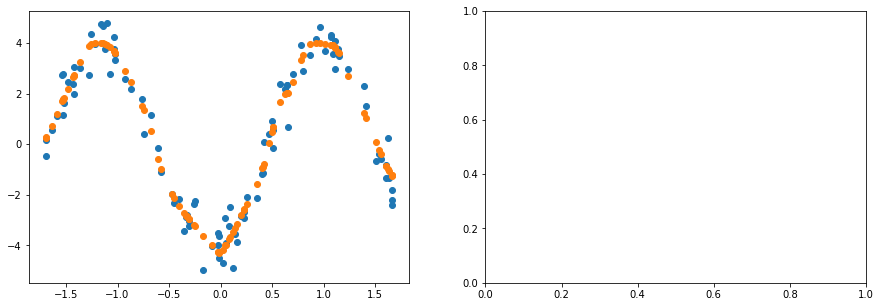

2699 loss q(w) -85.064697 p(w) -243.604462 p(y|xw) -148.287262 min -4.266290 mean 0.506546 max 4.490485
2699 loss q(w) -81.578224 p(w) -243.689590 p(y|xw) -115.984070 min -3.905082 mean 0.558760 max 4.100339
2699 loss q(w) -81.796455 p(w) -243.485977 p(y|xw) -125.009865 min -3.891145 mean 0.382168 max 3.783743
2699 loss q(w) -94.059181 p(w) -243.648300 p(y|xw) -116.764030 min -4.405642 mean 0.217435 max 4.223977
2699 loss q(w) -94.746605 p(w) -243.580521 p(y|xw) -164.320786 min -4.922080 mean 0.722685 max 4.792767
2699 loss q(w) -84.941879 p(w) -244.401535 p(y|xw) -157.415634 min -3.506127 mean 0.329950 max 4.152476
2699 loss q(w) -87.649719 p(w) -243.523178 p(y|xw) -125.246040 min -4.217283 mean 0.299789 max 3.456499
2699 loss q(w) -73.699135 p(w) -244.104233 p(y|xw) -121.025848 min -3.934425 mean 0.439695 max 3.571925
2699 loss q(w) -77.472206 p(w) -243.399918 p(y|xw) -111.850105 min -3.977649 mean 0.400801 max 3.767792
2699 loss q(w) -79.581100 p(w) -243.761292 p(y|xw) -114.047775 m

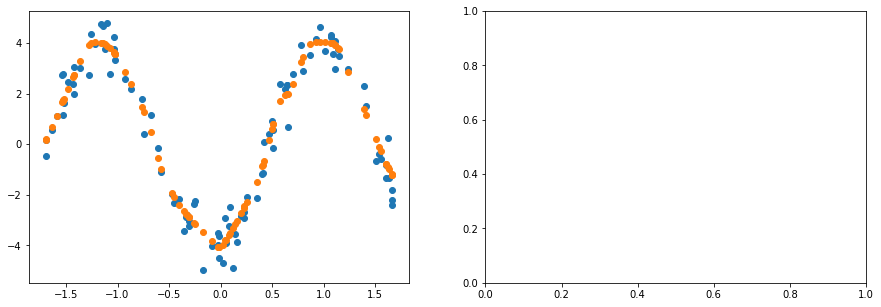

2799 loss q(w) -94.363525 p(w) -243.251358 p(y|xw) -122.515617 min -4.147446 mean 0.515406 max 4.123903
2799 loss q(w) -78.541100 p(w) -243.627487 p(y|xw) -124.384865 min -4.068873 mean 0.525623 max 4.123184
2799 loss q(w) -81.631165 p(w) -243.446640 p(y|xw) -110.132713 min -4.263281 mean 0.271368 max 3.928775
2799 loss q(w) -85.258949 p(w) -243.547867 p(y|xw) -121.846802 min -3.725178 mean 0.634808 max 3.841862
2799 loss q(w) -83.366547 p(w) -244.260437 p(y|xw) -100.488533 min -4.261433 mean 0.267086 max 4.039979
2799 loss q(w) -78.675156 p(w) -243.303253 p(y|xw) -118.691826 min -4.549923 mean 0.311724 max 3.833805
2799 loss q(w) -84.625481 p(w) -244.064835 p(y|xw) -116.964233 min -3.841068 mean 0.490515 max 3.973568
2799 loss q(w) -85.925117 p(w) -243.251205 p(y|xw) -137.900742 min -4.464846 mean 0.353221 max 3.737162
2799 loss q(w) -74.313705 p(w) -243.614426 p(y|xw) -106.129913 min -4.304023 mean 0.251286 max 3.890663
2799 loss q(w) -75.387238 p(w) -243.125900 p(y|xw) -101.832092 m

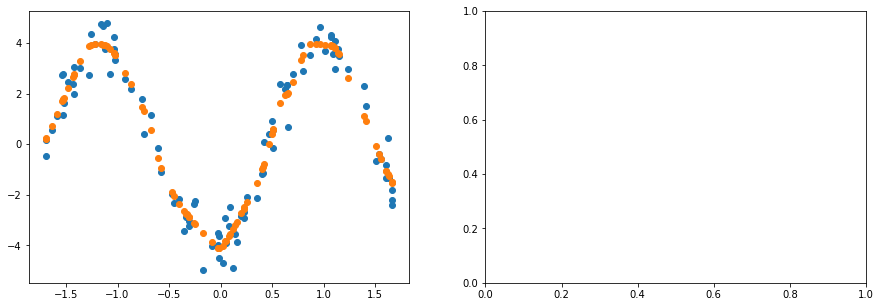

2899 loss q(w) -80.647652 p(w) -243.547211 p(y|xw) -118.655975 min -4.017601 mean 0.632916 max 4.142136
2899 loss q(w) -78.364494 p(w) -243.562836 p(y|xw) -96.408890 min -4.398245 mean 0.391861 max 3.938653
2899 loss q(w) -81.847160 p(w) -243.641144 p(y|xw) -106.580269 min -4.619574 mean 0.353535 max 4.146345
2899 loss q(w) -85.334175 p(w) -243.470184 p(y|xw) -123.501366 min -4.654825 mean 0.338152 max 4.206345
2899 loss q(w) -80.738167 p(w) -244.066818 p(y|xw) -132.488571 min -4.063436 mean 0.536255 max 4.182754
2899 loss q(w) -80.844284 p(w) -243.997406 p(y|xw) -101.424637 min -4.219976 mean 0.523051 max 4.103958
2899 loss q(w) -81.687271 p(w) -244.076492 p(y|xw) -110.522118 min -4.443044 mean 0.501088 max 4.545041
2899 loss q(w) -91.582039 p(w) -243.227814 p(y|xw) -138.023422 min -4.854706 mean 0.387999 max 3.673712
2899 loss q(w) -81.832520 p(w) -243.758987 p(y|xw) -102.311806 min -4.173048 mean 0.582714 max 4.379180
2899 loss q(w) -74.717651 p(w) -244.092209 p(y|xw) -127.105782 mi

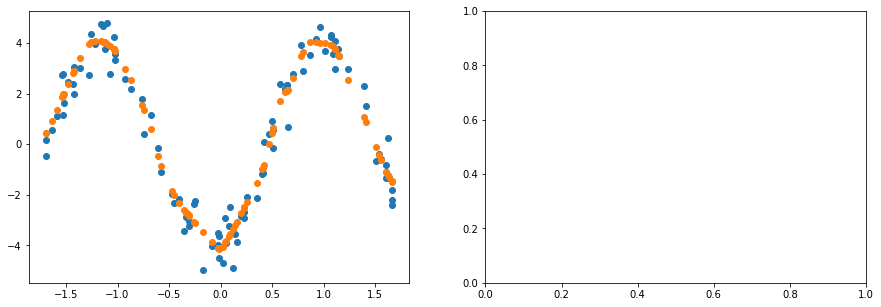

2999 loss q(w) -87.113518 p(w) -243.607956 p(y|xw) -120.484123 min -4.182639 mean 0.319277 max 3.574016
2999 loss q(w) -76.269333 p(w) -244.617996 p(y|xw) -121.541855 min -4.039899 mean 0.412865 max 3.641528
2999 loss q(w) -81.472588 p(w) -244.126495 p(y|xw) -103.694382 min -4.324333 mean 0.286107 max 3.697217
2999 loss q(w) -91.125397 p(w) -244.246948 p(y|xw) -146.467560 min -4.361350 mean 0.470706 max 4.449675
2999 loss q(w) -68.801491 p(w) -243.930038 p(y|xw) -103.102020 min -4.274075 mean 0.441760 max 4.034689
2999 loss q(w) -87.037567 p(w) -243.311661 p(y|xw) -140.598129 min -4.538138 mean 0.118630 max 4.001492
2999 loss q(w) -77.370735 p(w) -243.922638 p(y|xw) -111.444130 min -4.172309 mean 0.265751 max 3.606835
2999 loss q(w) -87.401733 p(w) -244.196365 p(y|xw) -103.964661 min -4.386774 mean 0.403917 max 3.931420
2999 loss q(w) -70.503838 p(w) -243.947433 p(y|xw) -103.036217 min -4.306644 mean 0.395920 max 4.096192
2999 loss q(w) -81.339790 p(w) -243.657013 p(y|xw) -98.453514 mi

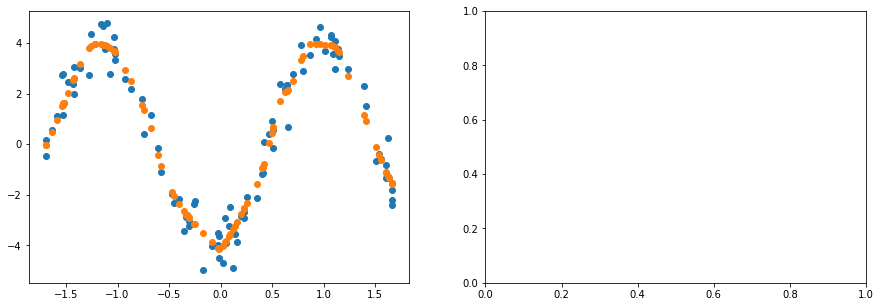

3099 loss q(w) -87.056808 p(w) -243.868393 p(y|xw) -105.241913 min -4.346969 mean 0.285515 max 4.165378
3099 loss q(w) -85.453972 p(w) -243.461349 p(y|xw) -131.741776 min -3.848845 mean 0.298429 max 4.420014
3099 loss q(w) -83.117043 p(w) -244.390610 p(y|xw) -103.381676 min -4.345199 mean 0.407365 max 4.125095
3099 loss q(w) -87.294159 p(w) -244.484680 p(y|xw) -132.583923 min -4.033723 mean 0.640816 max 4.358136
3099 loss q(w) -81.578232 p(w) -243.596069 p(y|xw) -110.159546 min -4.343741 mean 0.359242 max 3.947085
3099 loss q(w) -90.963867 p(w) -244.020142 p(y|xw) -107.100899 min -4.251661 mean 0.414914 max 4.326502
3099 loss q(w) -85.731941 p(w) -244.741257 p(y|xw) -116.732544 min -4.286212 mean 0.610058 max 4.321543
3099 loss q(w) -80.036224 p(w) -243.793533 p(y|xw) -119.542664 min -4.514198 mean 0.559773 max 4.167936
3099 loss q(w) -82.688049 p(w) -243.780289 p(y|xw) -110.947273 min -4.371469 mean 0.443331 max 3.801275
3099 loss q(w) -87.394051 p(w) -243.886810 p(y|xw) -143.104034 m

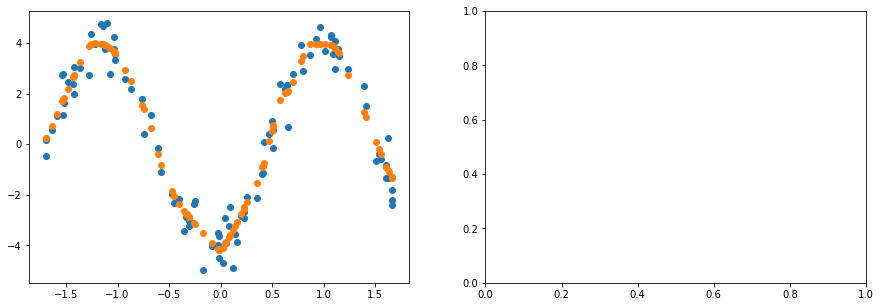

3199 loss q(w) -91.077133 p(w) -244.181000 p(y|xw) -110.261543 min -4.088861 mean 0.527703 max 3.918354
3199 loss q(w) -81.688278 p(w) -244.254059 p(y|xw) -99.815987 min -3.973263 mean 0.399345 max 4.231205
3199 loss q(w) -83.245323 p(w) -243.803299 p(y|xw) -117.561920 min -3.885302 mean 0.321073 max 3.653297
3199 loss q(w) -80.796150 p(w) -243.439499 p(y|xw) -104.598038 min -4.640918 mean 0.275653 max 3.767759
3199 loss q(w) -81.728615 p(w) -244.094040 p(y|xw) -102.916710 min -4.457541 mean 0.482909 max 4.522586
3199 loss q(w) -82.504814 p(w) -243.415833 p(y|xw) -107.932190 min -4.150271 mean 0.359796 max 4.523641
3199 loss q(w) -87.332993 p(w) -243.965103 p(y|xw) -119.147308 min -4.417544 mean 0.218652 max 3.681474
3199 loss q(w) -88.923225 p(w) -243.810135 p(y|xw) -127.614349 min -4.350869 mean 0.486482 max 4.404801
3199 loss q(w) -77.191895 p(w) -244.058105 p(y|xw) -108.851227 min -4.587879 mean 0.213368 max 3.718062
3199 loss q(w) -85.510818 p(w) -244.010910 p(y|xw) -108.974487 mi

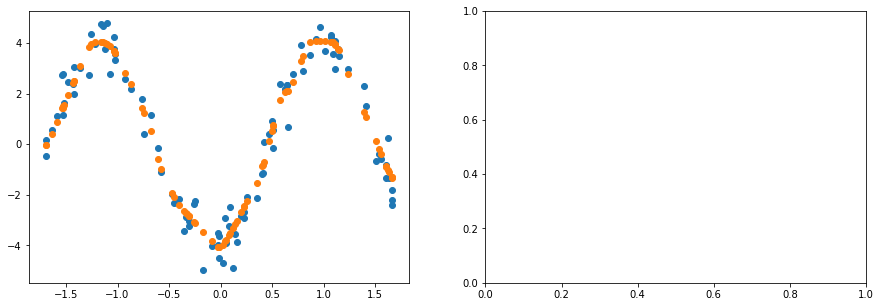

3299 loss q(w) -95.791779 p(w) -244.333710 p(y|xw) -122.196785 min -4.087483 mean 0.584588 max 4.236673
3299 loss q(w) -86.215508 p(w) -243.852356 p(y|xw) -114.799118 min -3.969896 mean 0.495899 max 4.555076
3299 loss q(w) -91.544556 p(w) -244.797211 p(y|xw) -116.847160 min -4.375930 mean 0.404526 max 3.897803
3299 loss q(w) -81.269272 p(w) -244.016190 p(y|xw) -104.877113 min -4.276122 mean 0.501279 max 4.520644
3299 loss q(w) -88.283424 p(w) -244.442276 p(y|xw) -105.998566 min -4.042113 mean 0.260097 max 4.060935
3299 loss q(w) -76.704216 p(w) -244.605194 p(y|xw) -107.309090 min -4.600617 mean 0.438937 max 4.085051
3299 loss q(w) -84.028030 p(w) -244.155655 p(y|xw) -102.190132 min -4.613510 mean 0.297737 max 3.817308
3299 loss q(w) -80.607826 p(w) -244.073242 p(y|xw) -116.174210 min -4.227030 mean 0.365400 max 3.533558
3299 loss q(w) -92.906731 p(w) -244.612991 p(y|xw) -138.355148 min -4.540015 mean 0.439186 max 4.115861
3299 loss q(w) -87.585663 p(w) -243.903427 p(y|xw) -127.553848 m

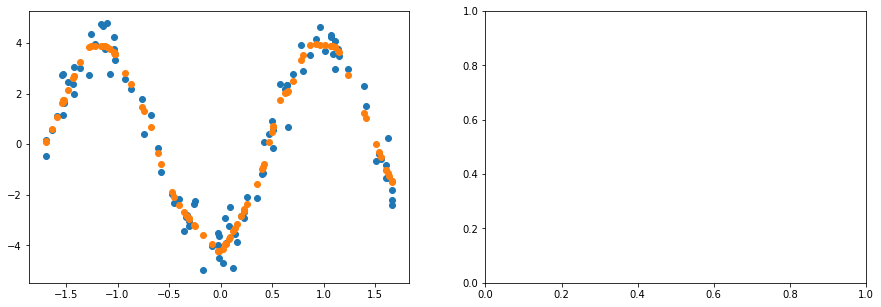

3399 loss q(w) -88.190681 p(w) -244.343643 p(y|xw) -124.046913 min -3.913128 mean 0.680694 max 4.776175
3399 loss q(w) -88.848457 p(w) -244.226288 p(y|xw) -104.996002 min -4.269481 mean 0.428861 max 4.266399
3399 loss q(w) -83.774948 p(w) -243.793182 p(y|xw) -115.888557 min -3.889151 mean 0.465368 max 4.312990
3399 loss q(w) -79.252853 p(w) -243.633957 p(y|xw) -102.842087 min -3.912707 mean 0.471575 max 4.098388
3399 loss q(w) -93.299728 p(w) -244.610886 p(y|xw) -132.973114 min -4.119101 mean 0.541368 max 4.566133
3399 loss q(w) -80.609444 p(w) -244.250381 p(y|xw) -115.812706 min -3.955978 mean 0.586515 max 4.020708
3399 loss q(w) -84.251015 p(w) -244.313873 p(y|xw) -104.038948 min -4.554602 mean 0.462301 max 4.001873
3399 loss q(w) -85.096352 p(w) -244.510422 p(y|xw) -119.151733 min -3.971964 mean 0.502052 max 3.661652
3399 loss q(w) -91.059212 p(w) -244.284546 p(y|xw) -103.361702 min -4.437884 mean 0.389919 max 3.737707
3399 loss q(w) -82.751938 p(w) -244.279922 p(y|xw) -114.229805 m

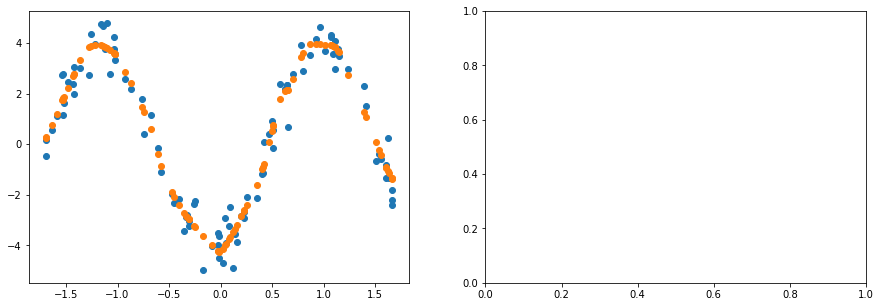

3499 loss q(w) -77.094170 p(w) -244.512863 p(y|xw) -96.578346 min -4.168792 mean 0.501514 max 4.128818
3499 loss q(w) -80.486046 p(w) -243.865250 p(y|xw) -120.611145 min -4.169388 mean 0.538760 max 4.133499
3499 loss q(w) -95.210960 p(w) -244.548080 p(y|xw) -105.129387 min -3.878354 mean 0.468013 max 3.911911
3499 loss q(w) -84.405563 p(w) -243.996353 p(y|xw) -110.723396 min -4.344543 mean 0.423789 max 4.222130
3499 loss q(w) -78.168167 p(w) -244.605255 p(y|xw) -124.988663 min -4.367033 mean 0.596470 max 4.377709
3499 loss q(w) -78.386986 p(w) -244.408981 p(y|xw) -99.253189 min -3.785291 mean 0.484386 max 4.105923
3499 loss q(w) -91.475784 p(w) -245.110489 p(y|xw) -97.230675 min -3.966480 mean 0.386851 max 4.033320
3499 loss q(w) -94.943405 p(w) -244.479202 p(y|xw) -108.407196 min -4.230290 mean 0.511197 max 4.480768
3499 loss q(w) -86.105652 p(w) -244.000107 p(y|xw) -103.835747 min -3.868704 mean 0.394727 max 3.900197
3499 loss q(w) -79.161522 p(w) -244.437195 p(y|xw) -112.869316 min 

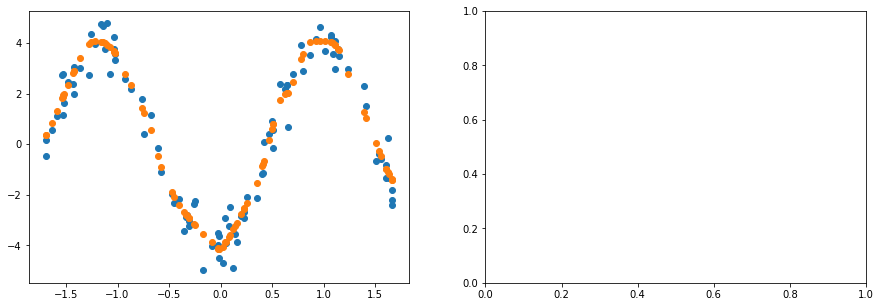

3599 loss q(w) -87.861885 p(w) -244.242294 p(y|xw) -131.713623 min -4.076988 mean 0.359436 max 3.829161
3599 loss q(w) -89.384560 p(w) -245.242859 p(y|xw) -105.190170 min -4.183733 mean 0.467046 max 4.391839
3599 loss q(w) -93.814224 p(w) -243.753586 p(y|xw) -132.638016 min -4.744725 mean 0.300642 max 4.072326
3599 loss q(w) -85.150375 p(w) -244.020462 p(y|xw) -116.952957 min -4.223874 mean 0.288159 max 4.168058
3599 loss q(w) -88.113884 p(w) -244.475204 p(y|xw) -125.896881 min -4.466753 mean 0.277410 max 3.446698
3599 loss q(w) -84.181519 p(w) -244.753082 p(y|xw) -111.750717 min -4.174106 mean 0.501344 max 4.143604
3599 loss q(w) -84.133430 p(w) -243.981613 p(y|xw) -116.190353 min -4.058694 mean 0.337222 max 3.723017
3599 loss q(w) -82.476616 p(w) -244.226807 p(y|xw) -111.596489 min -3.979915 mean 0.395352 max 3.571116
3599 loss q(w) -88.421997 p(w) -244.307663 p(y|xw) -124.875954 min -4.020230 mean 0.151705 max 3.660633
3599 loss q(w) -80.285538 p(w) -244.080566 p(y|xw) -135.852020 m

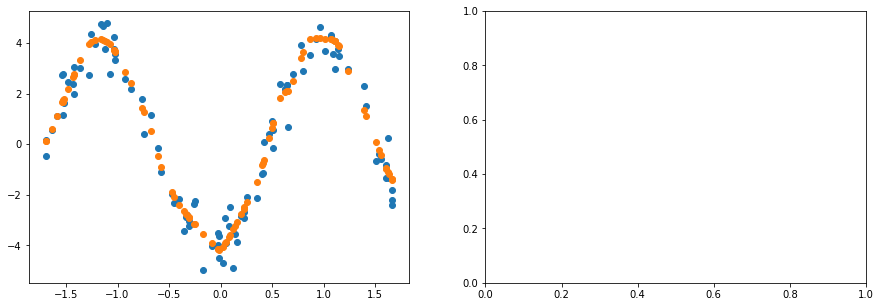

3699 loss q(w) -84.175125 p(w) -244.372070 p(y|xw) -103.575569 min -3.910467 mean 0.448468 max 3.963537
3699 loss q(w) -100.220421 p(w) -245.120392 p(y|xw) -130.545364 min -3.408513 mean 0.319825 max 3.579324
3699 loss q(w) -87.449814 p(w) -244.923843 p(y|xw) -126.849838 min -4.071658 mean 0.542259 max 4.327382
3699 loss q(w) -80.243240 p(w) -244.878754 p(y|xw) -108.489647 min -4.188083 mean 0.234197 max 3.903538
3699 loss q(w) -76.914177 p(w) -244.275742 p(y|xw) -114.733757 min -4.009920 mean 0.561373 max 4.112641
3699 loss q(w) -96.232269 p(w) -245.103195 p(y|xw) -122.138763 min -4.122527 mean 0.419983 max 3.854856
3699 loss q(w) -82.732796 p(w) -244.726288 p(y|xw) -115.652519 min -3.667562 mean 0.321305 max 3.504273
3699 loss q(w) -77.338425 p(w) -244.448380 p(y|xw) -110.048416 min -4.022627 mean 0.362476 max 3.631267
3699 loss q(w) -85.070511 p(w) -245.075867 p(y|xw) -96.492157 min -4.117057 mean 0.310384 max 3.712170
3699 loss q(w) -78.306259 p(w) -244.371445 p(y|xw) -107.079628 m

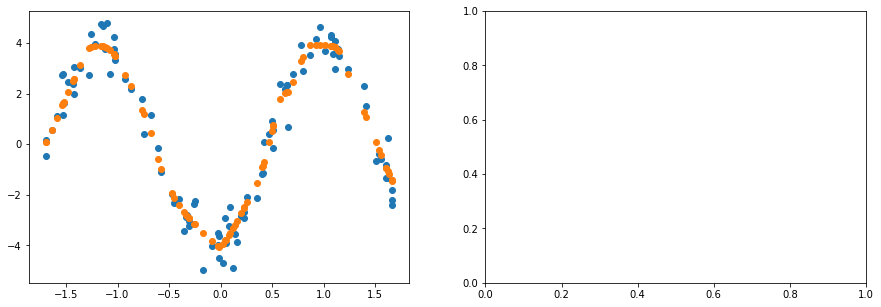

3799 loss q(w) -81.559822 p(w) -244.463470 p(y|xw) -108.696739 min -4.189778 mean 0.370213 max 3.937504
3799 loss q(w) -90.930824 p(w) -244.382523 p(y|xw) -119.132729 min -3.640685 mean 0.460802 max 4.001525
3799 loss q(w) -96.146980 p(w) -245.053207 p(y|xw) -109.112427 min -3.758178 mean 0.609632 max 4.471028
3799 loss q(w) -85.823242 p(w) -245.080109 p(y|xw) -115.037041 min -4.415596 mean 0.114196 max 3.716977
3799 loss q(w) -79.058273 p(w) -244.627869 p(y|xw) -97.814110 min -3.990119 mean 0.466457 max 3.898850
3799 loss q(w) -88.264740 p(w) -245.052872 p(y|xw) -124.297462 min -4.093666 mean 0.547578 max 4.089622
3799 loss q(w) -78.961044 p(w) -244.864624 p(y|xw) -110.415771 min -4.040781 mean 0.473582 max 4.313657
3799 loss q(w) -89.631958 p(w) -244.977997 p(y|xw) -119.575623 min -4.028445 mean 0.575657 max 4.142609
3799 loss q(w) -88.524063 p(w) -244.905441 p(y|xw) -120.769714 min -4.189587 mean 0.257973 max 3.781716
3799 loss q(w) -81.714928 p(w) -243.925751 p(y|xw) -98.980942 min

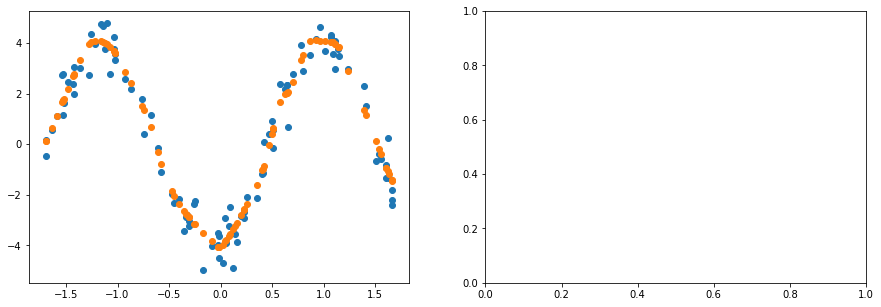

3899 loss q(w) -91.569771 p(w) -244.598785 p(y|xw) -103.128548 min -4.125926 mean 0.524862 max 4.195654
3899 loss q(w) -79.373703 p(w) -243.822876 p(y|xw) -137.250412 min -3.670924 mean 0.613775 max 4.130898
3899 loss q(w) -88.231735 p(w) -245.190094 p(y|xw) -115.600899 min -4.715477 mean 0.457295 max 3.865062
3899 loss q(w) -89.191338 p(w) -244.657501 p(y|xw) -101.206879 min -3.929953 mean 0.488131 max 4.064455
3899 loss q(w) -93.261620 p(w) -244.798935 p(y|xw) -97.998421 min -4.283884 mean 0.328228 max 4.093294
3899 loss q(w) -76.608170 p(w) -244.516129 p(y|xw) -121.346863 min -4.221637 mean 0.344710 max 4.063281
3899 loss q(w) -91.117485 p(w) -245.052063 p(y|xw) -139.220825 min -4.161130 mean 0.655738 max 4.556234
3899 loss q(w) -80.124130 p(w) -244.436493 p(y|xw) -111.885460 min -4.219399 mean 0.477771 max 3.999660
3899 loss q(w) -93.762093 p(w) -244.773087 p(y|xw) -149.567017 min -4.148627 mean 0.701839 max 3.930671
3899 loss q(w) -81.218063 p(w) -244.784790 p(y|xw) -110.109558 mi

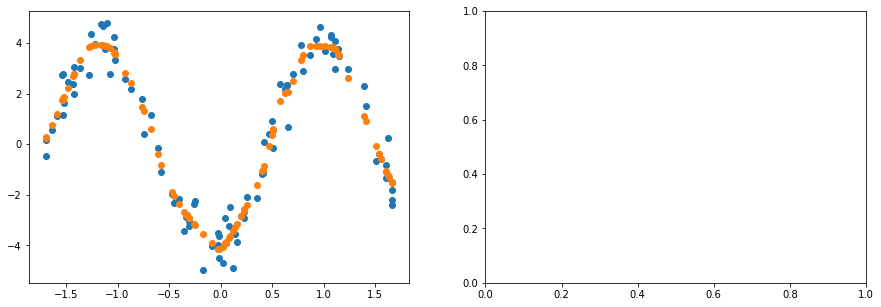

3999 loss q(w) -89.469246 p(w) -244.498123 p(y|xw) -104.022316 min -3.845537 mean 0.440420 max 3.895241
3999 loss q(w) -84.685867 p(w) -244.856812 p(y|xw) -101.175354 min -4.523503 mean 0.376504 max 3.768637
3999 loss q(w) -89.408554 p(w) -244.032608 p(y|xw) -108.592232 min -3.967687 mean 0.289179 max 3.956939
3999 loss q(w) -86.322281 p(w) -244.570786 p(y|xw) -129.040695 min -3.727200 mean 0.389528 max 3.924262
3999 loss q(w) -85.173286 p(w) -244.352356 p(y|xw) -100.169983 min -4.541379 mean 0.454455 max 4.198139
3999 loss q(w) -90.015831 p(w) -244.861023 p(y|xw) -93.991226 min -4.121799 mean 0.394661 max 3.904877
3999 loss q(w) -85.280373 p(w) -244.354095 p(y|xw) -111.799408 min -4.021678 mean 0.383516 max 4.153005
3999 loss q(w) -83.708748 p(w) -244.536362 p(y|xw) -120.982452 min -4.537094 mean 0.278269 max 4.291703
3999 loss q(w) -82.229073 p(w) -244.911026 p(y|xw) -95.943466 min -4.107203 mean 0.489640 max 4.341210
3999 loss q(w) -93.278160 p(w) -244.589584 p(y|xw) -122.834076 min

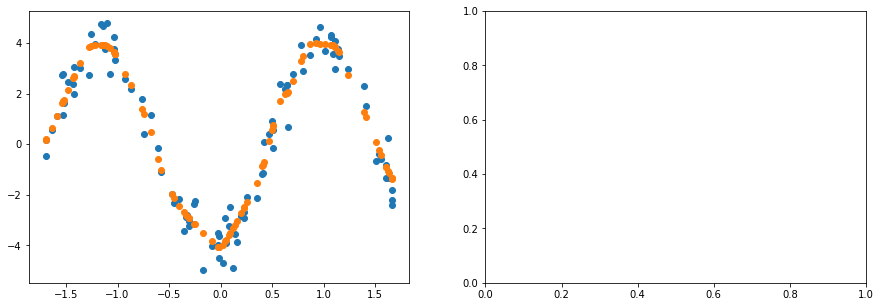

4099 loss q(w) -83.415215 p(w) -244.379044 p(y|xw) -129.663803 min -4.948019 mean 0.329219 max 3.650792
4099 loss q(w) -88.738380 p(w) -244.827606 p(y|xw) -115.498184 min -4.292369 mean 0.355313 max 3.842876
4099 loss q(w) -80.069298 p(w) -244.959366 p(y|xw) -94.891678 min -4.109636 mean 0.294878 max 3.904249
4099 loss q(w) -86.169151 p(w) -244.162292 p(y|xw) -114.530151 min -4.669050 mean 0.267457 max 4.506844
4099 loss q(w) -81.512459 p(w) -245.446457 p(y|xw) -100.882935 min -4.082532 mean 0.464970 max 4.113176
4099 loss q(w) -95.183449 p(w) -244.386429 p(y|xw) -118.640343 min -3.752166 mean 0.314412 max 4.029018
4099 loss q(w) -90.060089 p(w) -245.099884 p(y|xw) -123.402557 min -4.208031 mean 0.693770 max 4.385327
4099 loss q(w) -88.113503 p(w) -244.953476 p(y|xw) -119.882133 min -3.288107 mean 0.499813 max 3.882810
4099 loss q(w) -84.089127 p(w) -244.461624 p(y|xw) -102.385139 min -3.588837 mean 0.555723 max 4.248502
4099 loss q(w) -82.120468 p(w) -244.571808 p(y|xw) -101.636253 mi

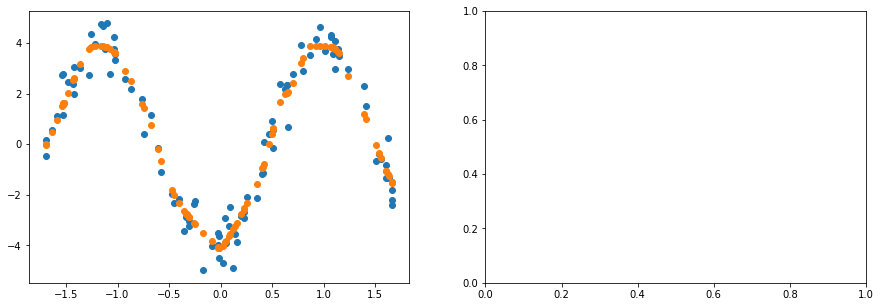

4199 loss q(w) -81.489487 p(w) -244.630890 p(y|xw) -100.431702 min -4.300808 mean 0.464345 max 3.950552
4199 loss q(w) -87.673363 p(w) -244.579178 p(y|xw) -119.260017 min -4.614315 mean 0.264365 max 3.850382
4199 loss q(w) -93.302574 p(w) -244.862900 p(y|xw) -101.040520 min -4.180648 mean 0.483420 max 4.075869
4199 loss q(w) -77.896416 p(w) -244.765823 p(y|xw) -124.028824 min -3.950937 mean 0.428413 max 4.121925
4199 loss q(w) -78.836090 p(w) -244.143890 p(y|xw) -106.095802 min -4.326599 mean 0.522663 max 3.947090
4199 loss q(w) -80.997437 p(w) -244.649673 p(y|xw) -104.553047 min -4.369081 mean 0.480242 max 4.293251
4199 loss q(w) -96.645744 p(w) -244.440445 p(y|xw) -123.019531 min -4.698357 mean 0.377335 max 4.000791
4199 loss q(w) -96.161819 p(w) -245.562561 p(y|xw) -112.398209 min -3.585440 mean 0.547693 max 4.184774
4199 loss q(w) -90.167244 p(w) -244.618362 p(y|xw) -123.597351 min -3.706260 mean 0.561775 max 4.627845
4199 loss q(w) -77.052338 p(w) -245.420853 p(y|xw) -107.281761 m

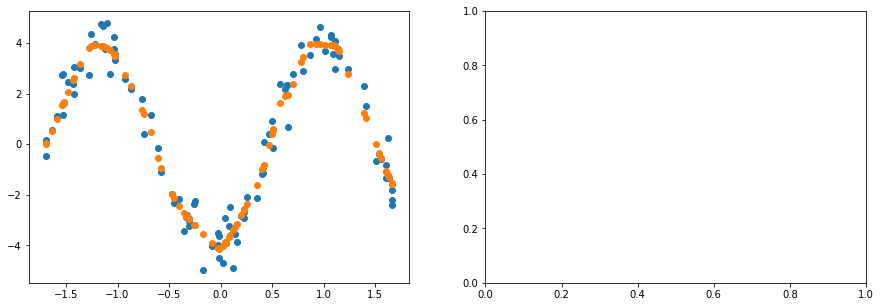

4299 loss q(w) -82.739967 p(w) -244.743668 p(y|xw) -104.366661 min -4.107390 mean 0.356439 max 4.022595
4299 loss q(w) -96.277779 p(w) -245.322159 p(y|xw) -134.639755 min -4.134428 mean 0.324784 max 3.854980
4299 loss q(w) -81.118263 p(w) -244.294388 p(y|xw) -106.763306 min -4.324975 mean 0.265619 max 3.940830
4299 loss q(w) -75.369034 p(w) -245.163788 p(y|xw) -94.517052 min -4.260264 mean 0.504726 max 4.179974
4299 loss q(w) -74.749054 p(w) -245.007111 p(y|xw) -103.767380 min -4.204662 mean 0.236605 max 3.720386
4299 loss q(w) -87.554565 p(w) -244.817963 p(y|xw) -115.311653 min -3.407968 mean 0.562880 max 4.124209
4299 loss q(w) -98.864670 p(w) -245.222580 p(y|xw) -109.112473 min -4.078858 mean 0.263493 max 3.579672
4299 loss q(w) -80.867867 p(w) -244.699844 p(y|xw) -102.608009 min -4.112751 mean 0.551510 max 4.105488
4299 loss q(w) -90.035400 p(w) -244.842972 p(y|xw) -108.945053 min -4.153972 mean 0.232178 max 4.035249
4299 loss q(w) -81.020157 p(w) -244.872864 p(y|xw) -124.571877 mi

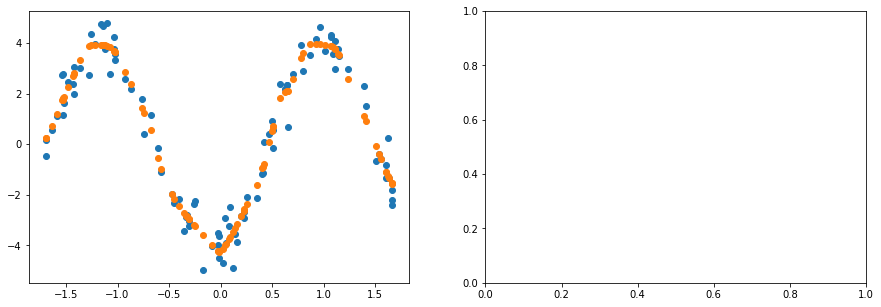

4399 loss q(w) -82.093613 p(w) -244.836563 p(y|xw) -107.569031 min -3.984007 mean 0.456248 max 4.098773
4399 loss q(w) -95.427132 p(w) -245.420319 p(y|xw) -107.789856 min -4.579295 mean 0.480582 max 4.167400
4399 loss q(w) -84.897774 p(w) -245.189636 p(y|xw) -117.187210 min -3.720428 mean 0.516400 max 4.594722
4399 loss q(w) -91.909492 p(w) -244.756439 p(y|xw) -141.755356 min -4.185568 mean 0.279025 max 4.384092
4399 loss q(w) -82.528435 p(w) -245.472595 p(y|xw) -99.331635 min -4.003953 mean 0.433735 max 3.939948
4399 loss q(w) -83.323425 p(w) -245.169876 p(y|xw) -113.882835 min -3.956424 mean 0.361617 max 3.674260
4399 loss q(w) -93.575981 p(w) -245.269028 p(y|xw) -109.727501 min -3.638312 mean 0.409180 max 3.861928
4399 loss q(w) -76.704430 p(w) -244.751495 p(y|xw) -116.399040 min -4.418933 mean 0.439293 max 3.678746
4399 loss q(w) -87.763641 p(w) -244.899475 p(y|xw) -97.392212 min -3.964171 mean 0.398294 max 3.872091
4399 loss q(w) -79.024940 p(w) -244.798203 p(y|xw) -98.686783 min 

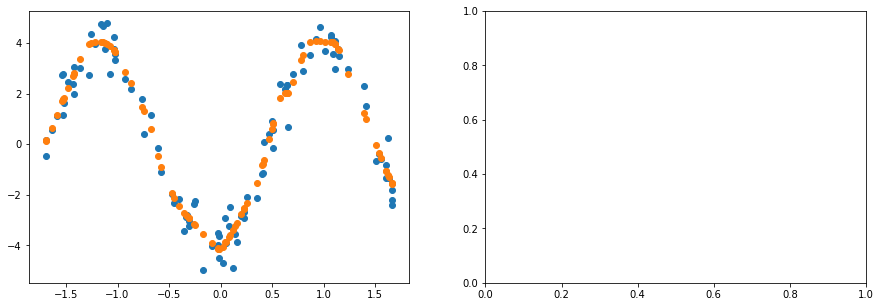

4499 loss q(w) -81.804573 p(w) -244.891129 p(y|xw) -112.311882 min -4.056194 mean 0.657532 max 4.584262
4499 loss q(w) -93.352570 p(w) -245.359665 p(y|xw) -105.267357 min -4.019665 mean 0.408926 max 4.141033
4499 loss q(w) -78.064476 p(w) -245.504425 p(y|xw) -105.416130 min -4.105235 mean 0.214520 max 3.873302
4499 loss q(w) -84.481949 p(w) -245.077774 p(y|xw) -115.368004 min -3.809281 mean 0.502578 max 4.305137
4499 loss q(w) -81.952980 p(w) -244.541458 p(y|xw) -109.635460 min -3.949526 mean 0.318780 max 3.876591
4499 loss q(w) -79.745605 p(w) -245.399323 p(y|xw) -104.493660 min -3.556741 mean 0.548785 max 4.414082
4499 loss q(w) -81.747772 p(w) -244.690186 p(y|xw) -125.661598 min -4.000879 mean 0.349212 max 4.099545
4499 loss q(w) -93.713905 p(w) -243.269821 p(y|xw) -966.825256 min -4.631697 mean 0.536644 max 4.526332
4499 loss q(w) -73.490868 p(w) -244.041779 p(y|xw) -103.490250 min -4.422699 mean 0.303231 max 4.136750
4499 loss q(w) -84.933510 p(w) -245.533844 p(y|xw) -111.012192 m

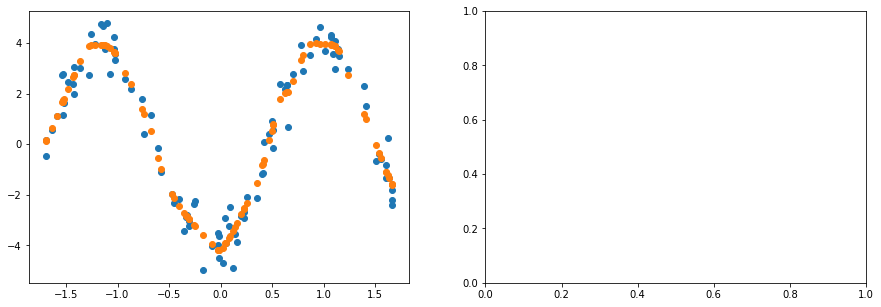

4599 loss q(w) -91.391098 p(w) -245.023468 p(y|xw) -108.883751 min -4.707831 mean 0.349590 max 4.394822
4599 loss q(w) -85.384300 p(w) -244.984909 p(y|xw) -117.121582 min -4.168979 mean 0.573338 max 4.487012
4599 loss q(w) -80.681526 p(w) -245.246170 p(y|xw) -95.641823 min -4.523093 mean 0.339323 max 3.990720
4599 loss q(w) -80.353714 p(w) -244.788971 p(y|xw) -113.221794 min -4.831467 mean 0.178277 max 3.958680
4599 loss q(w) -93.525124 p(w) -244.620026 p(y|xw) -118.567055 min -4.029150 mean 0.408107 max 3.751805
4599 loss q(w) -85.062851 p(w) -244.947235 p(y|xw) -124.883598 min -4.049189 mean 0.435093 max 4.341315
4599 loss q(w) -83.291924 p(w) -245.095886 p(y|xw) -101.248451 min -4.366451 mean 0.357321 max 4.130783
4599 loss q(w) -84.867058 p(w) -244.724518 p(y|xw) -119.901039 min -3.997705 mean 0.552307 max 3.883276
4599 loss q(w) -82.547310 p(w) -245.499283 p(y|xw) -100.944000 min -4.079651 mean 0.309130 max 3.707620
4599 loss q(w) -73.489342 p(w) -244.566589 p(y|xw) -99.840111 min

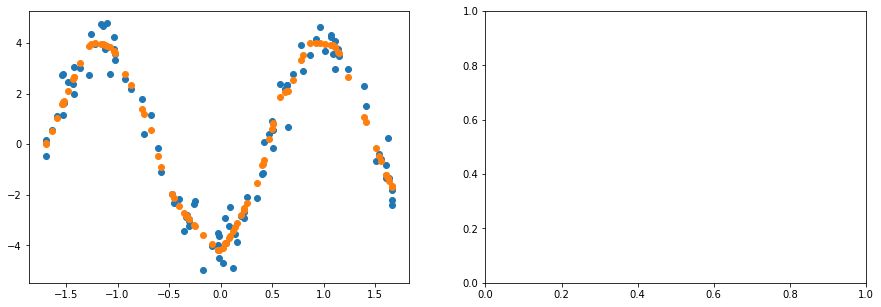

4699 loss q(w) -87.060936 p(w) -244.971436 p(y|xw) -111.961220 min -3.631671 mean 0.537902 max 3.729009
4699 loss q(w) -95.466522 p(w) -244.369324 p(y|xw) -142.190308 min -4.133182 mean 0.229668 max 4.484054
4699 loss q(w) -92.676071 p(w) -244.911285 p(y|xw) -99.551247 min -4.054556 mean 0.338386 max 3.809217
4699 loss q(w) -82.550995 p(w) -244.583298 p(y|xw) -99.548912 min -4.268218 mean 0.319496 max 3.822737
4699 loss q(w) -86.377823 p(w) -244.584854 p(y|xw) -112.651237 min -4.465341 mean 0.452284 max 3.960363
4699 loss q(w) -92.069450 p(w) -245.666290 p(y|xw) -151.685257 min -4.539088 mean 0.097035 max 3.459372
4699 loss q(w) -77.189003 p(w) -245.532471 p(y|xw) -102.891472 min -4.260758 mean 0.238367 max 4.077180
4699 loss q(w) -80.446487 p(w) -244.880783 p(y|xw) -138.092896 min -3.455902 mean 0.351251 max 3.670204
4699 loss q(w) -87.755875 p(w) -245.742752 p(y|xw) -124.679382 min -4.532333 mean 0.250769 max 4.264134
4699 loss q(w) -84.434532 p(w) -244.608856 p(y|xw) -123.062347 min

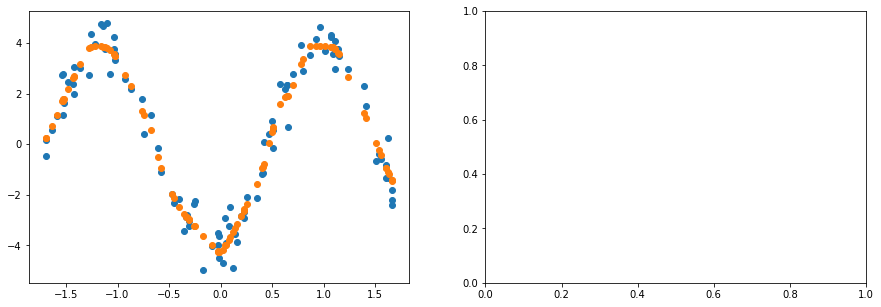

4799 loss q(w) -79.588623 p(w) -244.974976 p(y|xw) -111.298378 min -3.922626 mean 0.501042 max 4.275385
4799 loss q(w) -78.011955 p(w) -244.906998 p(y|xw) -112.527397 min -4.140992 mean 0.569309 max 4.038712
4799 loss q(w) -81.932823 p(w) -245.091492 p(y|xw) -112.677368 min -4.499569 mean 0.372449 max 4.064546
4799 loss q(w) -84.933922 p(w) -244.459717 p(y|xw) -103.053520 min -4.119399 mean 0.541255 max 4.183464
4799 loss q(w) -91.697121 p(w) -244.229218 p(y|xw) -106.071541 min -4.180354 mean 0.500071 max 4.334346
4799 loss q(w) -86.774506 p(w) -244.949783 p(y|xw) -121.430847 min -4.113729 mean 0.434538 max 3.654603
4799 loss q(w) -87.649864 p(w) -244.942032 p(y|xw) -103.453758 min -3.933345 mean 0.428074 max 4.049942
4799 loss q(w) -90.165733 p(w) -245.185455 p(y|xw) -99.743614 min -3.988264 mean 0.368519 max 4.040419
4799 loss q(w) -81.790489 p(w) -244.919312 p(y|xw) -103.570335 min -4.244170 mean 0.248864 max 3.662978
4799 loss q(w) -80.923828 p(w) -245.027069 p(y|xw) -104.196320 mi

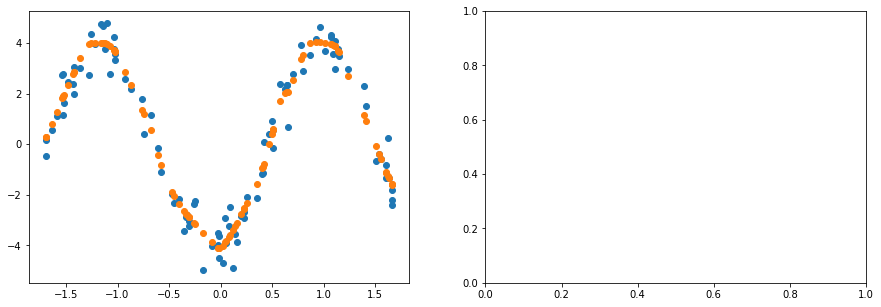

4899 loss q(w) -89.438766 p(w) -245.786377 p(y|xw) -113.264000 min -4.126536 mean 0.417956 max 4.076295
4899 loss q(w) -83.560631 p(w) -244.956604 p(y|xw) -106.879044 min -4.359388 mean 0.402082 max 3.989157
4899 loss q(w) -86.867447 p(w) -245.642914 p(y|xw) -99.800774 min -3.799903 mean 0.335661 max 3.772546
4899 loss q(w) -86.901527 p(w) -245.221649 p(y|xw) -98.317200 min -4.148807 mean 0.543663 max 4.080513
4899 loss q(w) -78.395988 p(w) -245.119705 p(y|xw) -110.321167 min -3.980806 mean 0.353630 max 3.730100
4899 loss q(w) -90.467590 p(w) -245.383362 p(y|xw) -102.981247 min -4.150962 mean 0.290882 max 3.735266
4899 loss q(w) -89.875862 p(w) -245.375214 p(y|xw) -117.996475 min -3.955930 mean 0.578456 max 3.898278
4899 loss q(w) -93.372032 p(w) -244.918213 p(y|xw) -100.320702 min -4.181538 mean 0.223095 max 3.842998
4899 loss q(w) -79.404243 p(w) -245.374130 p(y|xw) -107.953415 min -4.470089 mean 0.446548 max 3.940885
4899 loss q(w) -103.258865 p(w) -244.106323 p(y|xw) -117.167999 mi

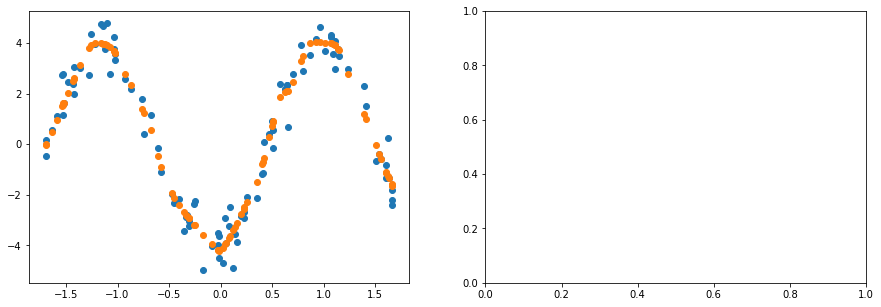

4999 loss q(w) -87.198250 p(w) -245.030792 p(y|xw) -106.448410 min -4.323948 mean 0.181883 max 3.595698
4999 loss q(w) -89.522171 p(w) -245.260712 p(y|xw) -100.299545 min -4.234109 mean 0.535791 max 4.089239
4999 loss q(w) -89.863174 p(w) -246.232986 p(y|xw) -98.777023 min -4.052181 mean 0.267257 max 3.897242
4999 loss q(w) -94.642601 p(w) -245.256424 p(y|xw) -119.469620 min -4.299403 mean 0.625965 max 4.013244
4999 loss q(w) -83.485504 p(w) -244.743805 p(y|xw) -130.221390 min -4.294395 mean 0.323106 max 4.227662
4999 loss q(w) -82.423912 p(w) -245.898697 p(y|xw) -102.395172 min -4.530156 mean 0.354443 max 4.162702
4999 loss q(w) -87.280754 p(w) -244.973526 p(y|xw) -106.561478 min -4.237269 mean 0.224994 max 3.601450
4999 loss q(w) -97.218536 p(w) -244.552048 p(y|xw) -116.441231 min -3.576212 mean 0.496987 max 3.949712
4999 loss q(w) -89.940880 p(w) -245.785004 p(y|xw) -106.184898 min -3.742915 mean 0.349514 max 3.628032
4999 loss q(w) -87.842972 p(w) -245.501724 p(y|xw) -112.817024 mi

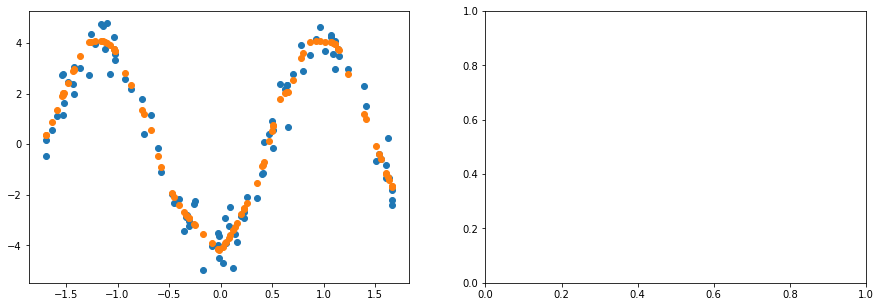

In [20]:
N_SAMPLES = 30
N_EPOCHS = 5000

scaler = StandardScaler()
x_train_norm = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)

# model = LinearNet2()
model = TensorLinearNet()
vimodel = VIModel(model)
q_w = vimodel.dist
p_w = normal_prior_dist(model)

# optimizer = torch.optim.Adam(params=vimodel.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(params=vimodel.parameters(), lr=1e-5, 
                            momentum=0.9,
                            weight_decay=1e-4)

def train():
    for i in range(N_EPOCHS):
        model.train()
        with torch.set_grad_enabled(True): 
            optimizer.zero_grad()        
            loss = kl_divergence_nsamples(q_w, p_w, vimodel.loc_dict, model, x_train_norm, y_train, N_SAMPLES, i)
            loss.backward()
            optimizer.step()        
            
        if str(loss.item()) == 'nan':
            break

        if (i+1) % 100== 0:
            # mu = vimodel.eta_mu.detach().numpy()
            # sigma = torch.exp(vimodel.eta_log_sigma.detach()).numpy()
            # print('loss: %f mu: %s sigma: %s' % (loss.detach().numpy(), str(mu), str(sigma)))
            # print(loss.size())
            print('iter: %d loss: %f ' % (i, loss.item(),))

            plt_prediction(q_w, vimodel.loc_dict, model, x_train_norm, y_train, 30)

train()

In [0]:
for n, p in vimodel.named_parameters():
    print(n, p)

## prediction

Calculate prediction distribution
$$
\begin{align}
p(y_*| x_*, X, Y) &= \int p(y_*| x_*, W) p(W| X, Y) dW \\
&\approx \int p(y_*| x_*, W) q(W; \eta) dW 
\end{align}
$$

In [0]:
def predict_data(q_w, loc_dict, model, n_samples):    
    x_pred = 5 * torch.rand(100, 1)
    x_pred = torch.tensor(scaler.transform(x_pred), dtype=torch.float32)
    y_pred = predict(q_w, loc_dict, model, x_pred, n_samples)
    
    return x_pred, y_pred


In [0]:
x_pred, y_pred = predict_data(q_w, vimodel.loc_dict, model, 10)
y_pred_train = predict(q_w, vimodel.loc_dict, model, x_train_norm, 10)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
print(len(axes))
axes[0].plot(x_train_norm.numpy(), y_train.numpy(), 'o')
axes[0].plot(x_train_norm.numpy(), y_pred_train.numpy(), 'o')
axes[0].plot(x_pred.numpy(), y_pred.numpy(), 'o')